# CIFAR10 Classification

In this part of the assignment we want to do an image classification task using PyTorch on CIFAR10 dataset.

## Import Libraries

Import needed libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt

## Device

Set device to work with (GPU or CPU)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Transforms & Dataset & Dataloader

Here, you should download and load the dataset with the desire transforms. After that, you should split train dataset to train and validation sets. Finally, define the dataloaders for `train`, `validation` and `test`

In [ ]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
Traintransform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

Testtransform = transforms.Compose([
    transforms.ToTensor(),
])


Trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=Traintransform)
Testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=Testtransform)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
Trainsize = int(0.9 * len(Trainset))
Valsize = len(Trainset) - Trainsize
Trainset, Valset = torch.utils.data.random_split(Trainset, (Trainsize, Valsize))

In [ ]:
Trainloader = torch.utils.data.DataLoader(Trainset, batch_size = 256, shuffle=True, num_workers=2)
Valloader = torch.utils.data.DataLoader(Valset, batch_size = 256, shuffle=True, num_workers=2)
Testloader = torch.utils.data.DataLoader(Testset, batch_size = 1024, shuffle = False, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Visualization

Visualize 5 random images from each class in different columns

- **Hint**:  You can use `plt.subplots` for visualization

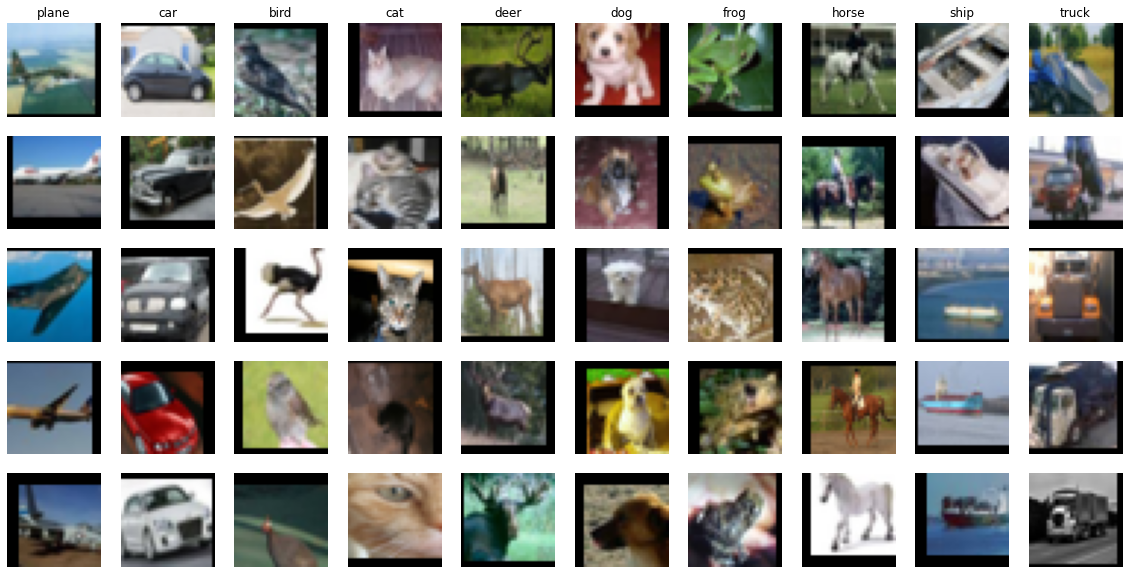

In [ ]:
img_classes = {i: [] for i in range(0, 10)}

counter = 0
i = 0
while counter != 50:
    img, label = Trainset[i]
    if len(img_classes[label]) != 5:
        img_classes[label].append(img)
        counter += 1
        
    i += 1
    
fig = plt.figure(figsize = (20, 10))
for i in range(50):
    fig.add_subplot(5, 10, i + 1)
    plt.imshow(img_classes[i%10][i//10].permute(1,2,0).numpy())
    if i // 10 == 0:
      plt.title(classes[i%10])
    plt.axis('off')
    
plt.show()

## Model

Define your model here from scratch (You are not allowed to use the existing models in pytorch)

**NOTICE:** The model that you will have defined outputs a vector containing 10 numbers (for each class). Define a "feature space" that is a vector of size *N* (where *N > 10*) right before the last layer (You can then have a last layer like `nn.Linear(N, 10)`). See the image below to get a better understanding. We will use this later (we want to access the feature space of a sample when the sample is given to the model). The model tries to learn a representation of the samples in this feature space and we will see how good it could do this in later sections.

![Feature Space In Neural Network](https://i.postimg.cc/28Qjcn9D/feature-space-vis.png)

- **Hint I**: Our goal is to get accuracy above *90%* on testset. Our suggestion is to implement ResNet (ResNet18 could be a viable choice)
  - You can learn the network's structure and implementation online (Youtube, ...) and then implmenet it yourself and make changes to enhance it's performance on our task **(YOU SHOULD NOT COPY THE CODE!!! OTHERWISE, YOU'LL BE PENALIZED!!!)**

- **Hint II**: When defining your model, pay attension to the **NOTICE** part in the above. It's also better to read the "Exploring the feature space" section beforehand.  

In [ ]:

class block(nn.Module):
    def __init__(self, in_channels, out_channels, identity_func=None, stride=1):
        super(block, self).__init__()
        self.identity_func = identity_func
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1)
        self.batch1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1)
        self.batch2 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU()
        
    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.batch1(x)
        x = self.conv2(x)
        x = self.batch2(x)
        
        if self.identity_func is not None:
            identity = self.identity_func(identity)
        
        x += identity
        x = self.relu1(x)
        
        return x
    
class ResNet(nn.Module):
    def __init__(self, block, img_channels, num_classes, layers):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(img_channels, 64, 3, 1, 1, bias = False)
        self.batch1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()
        # self.maxpool = nn.MaxPool2d(3, 2, 1)
        
        self.layer1 = self._make_layer(block, layers[0], 64, 1)
        self.layer2 = self._make_layer(block, layers[1], 128, 2)
        self.layer3 = self._make_layer(block, layers[2], 256, 2)
        self.layer4 = self._make_layer(block, layers[3], 512, 2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.batch1(x)
        x = self.relu1(x)
        
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = F.avg_pool2d(x, 4)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        
        return x
        
    def get_feature_vector(self, x):
        x = self.conv1(x)
        x = self.batch1(x)
        x = self.relu1(x)
        
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = F.avg_pool2d(x, 4)
        x = x.reshape(x.shape[0], -1)
        return x
        
    def _make_layer(self, block, num_blocks, out_channels, stride):
        layer = []
        identity = None
        
        if stride != 1 or out_channels != 64:
            identity = nn.Sequential(nn.Conv2d(out_channels // 2, out_channels, 1, stride), nn.BatchNorm2d(out_channels))
          
        if out_channels == 64:
            layer.append(block(out_channels, out_channels))
        else:
            layer.append(block(out_channels // 2, out_channels, identity, stride))
        
        
        for _ in range(num_blocks - 1):
            layer.append(block(out_channels, out_channels))
            
        return nn.Sequential(*layer)
    
    
def ResNet18(img_channels, num_classes):
    return ResNet(block, img_channels, num_classes, [2, 2, 2, 2])
      

## Train

### Model instantiation

Create an instance of your model and move it to `device`

In [ ]:
net = ResNet18(3, 10)
net.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (batch1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (layer1): Sequential(
    (0): block(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batch1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batch2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
    )
    (1): block(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batch1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batch2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

### Criterion & Optimizater

Define `criterion` and `optimizer` (Or `scheduler`)

In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingLR
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum = 0.9, weight_decay=0.0002)
scheduler = CosineAnnealingLR(optimizer, T_max = 200)

### Train loop

Train your model 

Tasks:
- [ ] Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Train accuracy
  - Validation loss
  - Validation accuracy
- [ ] save train/validation loss and accuracy (of each epoch) in an array for later usage

In [ ]:
import tqdm

In [ ]:
def train_epoch(model, criterion, optimizer, train_losses, train_accuracies, dataloader):
    model.train()
    
    running_loss = 0
    num_correct = 0
    total = 0
    
    with tqdm.tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
        for i, (images, labels) in pbar:
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
        
            o = model(images)
            loss = criterion(o, labels)
            loss.backward()
            optimizer.step()
        
            running_loss += loss.item()
            _, predict = o.max(1)
            total += labels.size(0)
            num_correct += predict.eq(labels).sum().item()
        
    train_loss = running_loss / len(dataloader)
    train_accuracy = 100.0 * (num_correct/total)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    print(f'train loss: {train_loss}, train accuracy: {train_accuracy}')

In [ ]:
def eval_epoch(model, criterion, eval_losses, eval_accuracies, dataloader):
    model.eval()
    
    running_loss = 0
    num_correct = 0
    total = 0
    
    with torch.no_grad(), tqdm.tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
        for i, (images, labels) in pbar:
            images = images.to(device)
            labels = labels.to(device)
            
            o = model(images)
            loss = criterion(o, labels)
            
            _, predict = o.max(1)
            running_loss += loss.item()
            total += labels.size(0)
            num_correct += predict.eq(labels).sum().item()
    eval_loss = running_loss / len(dataloader)
    eval_accuracy = 100.0 * (num_correct/total)
    
    eval_losses.append(eval_loss)
    eval_accuracies.append(eval_accuracy)
    
    print(f'evaluation loss: {eval_loss}, evaluation accuracy: {eval_accuracy}')

In [ ]:
train_losses = []
train_accuracies = []
eval_losses = []
eval_accuracies = []
epoch = 50
for i in range(1, epoch + 1):
    print(f'Epoch {i}')
    train_epoch(net, criterion, optimizer, train_losses, train_accuracies, Trainloader)
    eval_epoch(net, criterion, eval_losses, eval_accuracies, Valloader)
    scheduler.step()

Epoch 1


100%|██████████| 176/176 [00:42<00:00,  4.13it/s]

train loss: 1.4797863804481246, train accuracy: 45.40222222222222



100%|██████████| 20/20 [00:01<00:00, 12.96it/s]

evaluation loss: 2.1931804358959197, evaluation accuracy: 34.42
Epoch 2



100%|██████████| 176/176 [00:36<00:00,  4.77it/s]

train loss: 1.0381465259600768, train accuracy: 62.84444444444445



100%|██████████| 20/20 [00:01<00:00, 12.87it/s]

evaluation loss: 1.072534629702568, evaluation accuracy: 62.019999999999996
Epoch 3



100%|██████████| 176/176 [00:37<00:00,  4.68it/s]

train loss: 0.8469566960226406, train accuracy: 69.96



100%|██████████| 20/20 [00:01<00:00, 12.62it/s]

evaluation loss: 2.0604726672172546, evaluation accuracy: 45.94
Epoch 4



100%|██████████| 176/176 [00:37<00:00,  4.64it/s]

train loss: 0.7229023613035679, train accuracy: 74.65555555555555



100%|██████████| 20/20 [00:01<00:00, 12.67it/s]

evaluation loss: 0.7670890301465988, evaluation accuracy: 73.02
Epoch 5



100%|██████████| 176/176 [00:37<00:00,  4.67it/s]

train loss: 0.6514724919741804, train accuracy: 77.33333333333333



100%|██████████| 20/20 [00:01<00:00, 12.28it/s]

evaluation loss: 0.675355912744999, evaluation accuracy: 76.12
Epoch 6



100%|██████████| 176/176 [00:38<00:00,  4.63it/s]

train loss: 0.5879668175158176, train accuracy: 79.53333333333333



100%|██████████| 20/20 [00:01<00:00, 12.65it/s]

evaluation loss: 0.6523289531469345, evaluation accuracy: 77.44
Epoch 7



100%|██████████| 176/176 [00:37<00:00,  4.64it/s]

train loss: 0.5275836246596142, train accuracy: 81.72666666666667



100%|██████████| 20/20 [00:01<00:00, 12.88it/s]

evaluation loss: 0.6185547649860382, evaluation accuracy: 78.25999999999999
Epoch 8



100%|██████████| 176/176 [00:37<00:00,  4.64it/s]

train loss: 0.4934598368338563, train accuracy: 82.81333333333333



100%|██████████| 20/20 [00:01<00:00, 12.62it/s]

evaluation loss: 0.5616262227296829, evaluation accuracy: 80.30000000000001
Epoch 9



100%|██████████| 176/176 [00:37<00:00,  4.64it/s]

train loss: 0.4601471205665307, train accuracy: 83.8711111111111



100%|██████████| 20/20 [00:01<00:00, 12.58it/s]

evaluation loss: 0.699486929178238, evaluation accuracy: 76.68
Epoch 10



100%|██████████| 176/176 [00:37<00:00,  4.63it/s]

train loss: 0.4384920278733427, train accuracy: 84.86444444444444



100%|██████████| 20/20 [00:01<00:00, 12.62it/s]

evaluation loss: 0.5562095314264297, evaluation accuracy: 81.26
Epoch 11



100%|██████████| 176/176 [00:38<00:00,  4.62it/s]

train loss: 0.40263036503033206, train accuracy: 85.89777777777778



100%|██████████| 20/20 [00:01<00:00, 12.63it/s]

evaluation loss: 0.5775724500417709, evaluation accuracy: 80.58
Epoch 12



100%|██████████| 176/176 [00:38<00:00,  4.63it/s]

train loss: 0.38415198028087616, train accuracy: 86.7



100%|██████████| 20/20 [00:01<00:00, 12.71it/s]

evaluation loss: 0.5406393840909004, evaluation accuracy: 81.96
Epoch 13



100%|██████████| 176/176 [00:37<00:00,  4.64it/s]

train loss: 0.36993069100109016, train accuracy: 87.2088888888889



100%|██████████| 20/20 [00:01<00:00, 12.82it/s]

evaluation loss: 0.541789910197258, evaluation accuracy: 82.38
Epoch 14



100%|██████████| 176/176 [00:38<00:00,  4.63it/s]

train loss: 0.343195775185119, train accuracy: 87.94222222222223



100%|██████████| 20/20 [00:01<00:00, 12.65it/s]

evaluation loss: 0.48858218640089035, evaluation accuracy: 82.86
Epoch 15



100%|██████████| 176/176 [00:38<00:00,  4.62it/s]

train loss: 0.33005572635341773, train accuracy: 88.43555555555555



100%|██████████| 20/20 [00:01<00:00, 12.75it/s]

evaluation loss: 0.44525638967752457, evaluation accuracy: 85.2
Epoch 16



100%|██████████| 176/176 [00:37<00:00,  4.64it/s]

train loss: 0.30901065333323047, train accuracy: 89.21111111111111



100%|██████████| 20/20 [00:01<00:00, 12.70it/s]

evaluation loss: 0.504262512922287, evaluation accuracy: 83.46000000000001
Epoch 17



100%|██████████| 176/176 [00:38<00:00,  4.63it/s]

train loss: 0.2942925617945465, train accuracy: 89.77555555555556



100%|██████████| 20/20 [00:01<00:00, 12.49it/s]

evaluation loss: 0.47022998332977295, evaluation accuracy: 83.88
Epoch 18



100%|██████████| 176/176 [00:38<00:00,  4.63it/s]

train loss: 0.2817345451224934, train accuracy: 90.11333333333333



100%|██████████| 20/20 [00:01<00:00, 12.84it/s]

evaluation loss: 0.4337091386318207, evaluation accuracy: 86.24000000000001
Epoch 19



100%|██████████| 176/176 [00:37<00:00,  4.64it/s]

train loss: 0.26659577966413717, train accuracy: 90.73777777777778



100%|██████████| 20/20 [00:01<00:00, 12.75it/s]

evaluation loss: 0.44917894154787064, evaluation accuracy: 85.64
Epoch 20



100%|██████████| 176/176 [00:37<00:00,  4.65it/s]

train loss: 0.2536758707666939, train accuracy: 91.07333333333332



100%|██████████| 20/20 [00:01<00:00, 12.46it/s]

evaluation loss: 0.4227951720356941, evaluation accuracy: 86.32
Epoch 21



100%|██████████| 176/176 [00:38<00:00,  4.62it/s]

train loss: 0.2461554411460053, train accuracy: 91.39777777777778



100%|██████████| 20/20 [00:01<00:00, 12.53it/s]

evaluation loss: 0.3914489850401878, evaluation accuracy: 86.78
Epoch 22



100%|██████████| 176/176 [00:38<00:00,  4.63it/s]

train loss: 0.23425349275666205, train accuracy: 91.7911111111111



100%|██████████| 20/20 [00:01<00:00, 12.92it/s]

evaluation loss: 0.4057072252035141, evaluation accuracy: 87.0
Epoch 23



100%|██████████| 176/176 [00:38<00:00,  4.61it/s]

train loss: 0.2266604621809992, train accuracy: 91.91333333333334



100%|██████████| 20/20 [00:01<00:00, 12.44it/s]

evaluation loss: 0.4278361082077026, evaluation accuracy: 86.18
Epoch 24



100%|██████████| 176/176 [00:38<00:00,  4.61it/s]

train loss: 0.2152689954011955, train accuracy: 92.49555555555555



100%|██████████| 20/20 [00:01<00:00, 12.69it/s]

evaluation loss: 0.45307025462388995, evaluation accuracy: 85.66
Epoch 25



100%|██████████| 176/176 [00:38<00:00,  4.61it/s]

train loss: 0.20885338054292582, train accuracy: 92.67777777777778



100%|██████████| 20/20 [00:01<00:00, 12.45it/s]

evaluation loss: 0.39654828459024427, evaluation accuracy: 87.14
Epoch 26



100%|██████████| 176/176 [00:38<00:00,  4.61it/s]

train loss: 0.1967202307741073, train accuracy: 93.00444444444445



100%|██████████| 20/20 [00:01<00:00, 12.64it/s]

evaluation loss: 0.38884436190128324, evaluation accuracy: 87.66000000000001
Epoch 27



100%|██████████| 176/176 [00:38<00:00,  4.61it/s]

train loss: 0.18938334455544298, train accuracy: 93.36222222222223



100%|██████████| 20/20 [00:01<00:00, 12.65it/s]

evaluation loss: 0.40205671787261965, evaluation accuracy: 87.44
Epoch 28



100%|██████████| 176/176 [00:38<00:00,  4.62it/s]

train loss: 0.18409457028081472, train accuracy: 93.42222222222222



100%|██████████| 20/20 [00:01<00:00, 12.51it/s]

evaluation loss: 0.43817234337329863, evaluation accuracy: 87.0
Epoch 29



100%|██████████| 176/176 [00:37<00:00,  4.63it/s]

train loss: 0.1717673746276308, train accuracy: 93.98222222222222



100%|██████████| 20/20 [00:01<00:00, 12.84it/s]

evaluation loss: 0.4089185670018196, evaluation accuracy: 87.7
Epoch 30



100%|██████████| 176/176 [00:38<00:00,  4.62it/s]

train loss: 0.16569719234989447, train accuracy: 94.19333333333333



100%|██████████| 20/20 [00:01<00:00, 12.85it/s]

evaluation loss: 0.4138549745082855, evaluation accuracy: 86.68
Epoch 31



100%|██████████| 176/176 [00:37<00:00,  4.63it/s]

train loss: 0.16234243695031514, train accuracy: 94.21333333333334



100%|██████████| 20/20 [00:01<00:00, 12.57it/s]

evaluation loss: 0.39080353230237963, evaluation accuracy: 87.6
Epoch 32



100%|██████████| 176/176 [00:38<00:00,  4.63it/s]

train loss: 0.15635114484889942, train accuracy: 94.44888888888889



100%|██████████| 20/20 [00:01<00:00, 12.50it/s]

evaluation loss: 0.3869200274348259, evaluation accuracy: 88.08
Epoch 33



100%|██████████| 176/176 [00:38<00:00,  4.62it/s]

train loss: 0.1481296617791734, train accuracy: 94.77333333333333



100%|██████████| 20/20 [00:01<00:00, 12.68it/s]

evaluation loss: 0.39365802258253096, evaluation accuracy: 87.94
Epoch 34



100%|██████████| 176/176 [00:38<00:00,  4.62it/s]

train loss: 0.14308247321539305, train accuracy: 94.81555555555555



100%|██████████| 20/20 [00:01<00:00, 12.61it/s]

evaluation loss: 0.36909202486276627, evaluation accuracy: 88.96
Epoch 35



100%|██████████| 176/176 [00:37<00:00,  4.63it/s]

train loss: 0.13316356792876666, train accuracy: 95.25333333333333



100%|██████████| 20/20 [00:01<00:00, 12.77it/s]

evaluation loss: 0.3979259207844734, evaluation accuracy: 87.88
Epoch 36



100%|██████████| 176/176 [00:38<00:00,  4.63it/s]

train loss: 0.13337110719558867, train accuracy: 95.2488888888889



100%|██████████| 20/20 [00:01<00:00, 12.55it/s]

evaluation loss: 0.38732636868953707, evaluation accuracy: 88.08
Epoch 37



100%|██████████| 176/176 [00:38<00:00,  4.63it/s]

train loss: 0.12267732620239258, train accuracy: 95.65777777777778



100%|██████████| 20/20 [00:01<00:00, 12.50it/s]

evaluation loss: 0.3814509466290474, evaluation accuracy: 88.96
Epoch 38



100%|██████████| 176/176 [00:38<00:00,  4.63it/s]

train loss: 0.1212623434733938, train accuracy: 95.71777777777778



100%|██████████| 20/20 [00:01<00:00, 12.79it/s]

evaluation loss: 0.3747373640537262, evaluation accuracy: 88.75999999999999
Epoch 39



100%|██████████| 176/176 [00:38<00:00,  4.62it/s]

train loss: 0.11921719152649696, train accuracy: 95.70666666666666



100%|██████████| 20/20 [00:01<00:00, 12.56it/s]

evaluation loss: 0.39170499742031095, evaluation accuracy: 88.8
Epoch 40



100%|██████████| 176/176 [00:38<00:00,  4.61it/s]

train loss: 0.10768590939485213, train accuracy: 96.16



100%|██████████| 20/20 [00:01<00:00, 12.46it/s]

evaluation loss: 0.4052355960011482, evaluation accuracy: 87.78
Epoch 41



100%|██████████| 176/176 [00:38<00:00,  4.61it/s]

train loss: 0.10847310048782012, train accuracy: 96.15555555555557



100%|██████████| 20/20 [00:01<00:00, 12.56it/s]

evaluation loss: 0.4170085430145264, evaluation accuracy: 88.14
Epoch 42



100%|██████████| 176/176 [00:38<00:00,  4.61it/s]

train loss: 0.10415965841490436, train accuracy: 96.35777777777777



100%|██████████| 20/20 [00:01<00:00, 12.55it/s]

evaluation loss: 0.3979936301708221, evaluation accuracy: 88.88000000000001
Epoch 43



100%|██████████| 176/176 [00:38<00:00,  4.61it/s]

train loss: 0.09549855614419687, train accuracy: 96.66



100%|██████████| 20/20 [00:01<00:00, 12.35it/s]

evaluation loss: 0.3585794687271118, evaluation accuracy: 89.34
Epoch 44



100%|██████████| 176/176 [00:38<00:00,  4.62it/s]

train loss: 0.09125380842438476, train accuracy: 96.77333333333334



100%|██████████| 20/20 [00:01<00:00, 12.57it/s]

evaluation loss: 0.4111002653837204, evaluation accuracy: 88.56
Epoch 45



100%|██████████| 176/176 [00:38<00:00,  4.61it/s]

train loss: 0.0872093073240566, train accuracy: 96.90666666666667



100%|██████████| 20/20 [00:01<00:00, 12.50it/s]

evaluation loss: 0.3883546471595764, evaluation accuracy: 89.12
Epoch 46



100%|██████████| 176/176 [00:38<00:00,  4.61it/s]

train loss: 0.08424305083992129, train accuracy: 96.98444444444443



100%|██████████| 20/20 [00:01<00:00, 12.42it/s]

evaluation loss: 0.3834355600178242, evaluation accuracy: 88.96
Epoch 47



100%|██████████| 176/176 [00:38<00:00,  4.62it/s]

train loss: 0.08387926451607862, train accuracy: 96.96000000000001



100%|██████████| 20/20 [00:01<00:00, 12.72it/s]

evaluation loss: 0.3798205628991127, evaluation accuracy: 89.44
Epoch 48



100%|██████████| 176/176 [00:38<00:00,  4.61it/s]

train loss: 0.07868609226054767, train accuracy: 97.21555555555555



100%|██████████| 20/20 [00:01<00:00, 10.73it/s]

evaluation loss: 0.4270767763257027, evaluation accuracy: 88.26
Epoch 49



100%|██████████| 176/176 [00:38<00:00,  4.61it/s]

train loss: 0.08068320021795278, train accuracy: 97.13555555555556



100%|██████████| 20/20 [00:01<00:00, 12.49it/s]

evaluation loss: 0.3559344783425331, evaluation accuracy: 90.14
Epoch 50



100%|██████████| 176/176 [00:38<00:00,  4.62it/s]

train loss: 0.07170246661090376, train accuracy: 97.48666666666666



100%|██████████| 20/20 [00:01<00:00, 12.57it/s]

evaluation loss: 0.3815823018550873, evaluation accuracy: 89.38000000000001


### Visualize Loss and Accuracy plot

Using the arrays that you have (from task 2 in the above section), visualize two plots: Accuracy plot (train and validation together) and Loss plot (train and validation together)

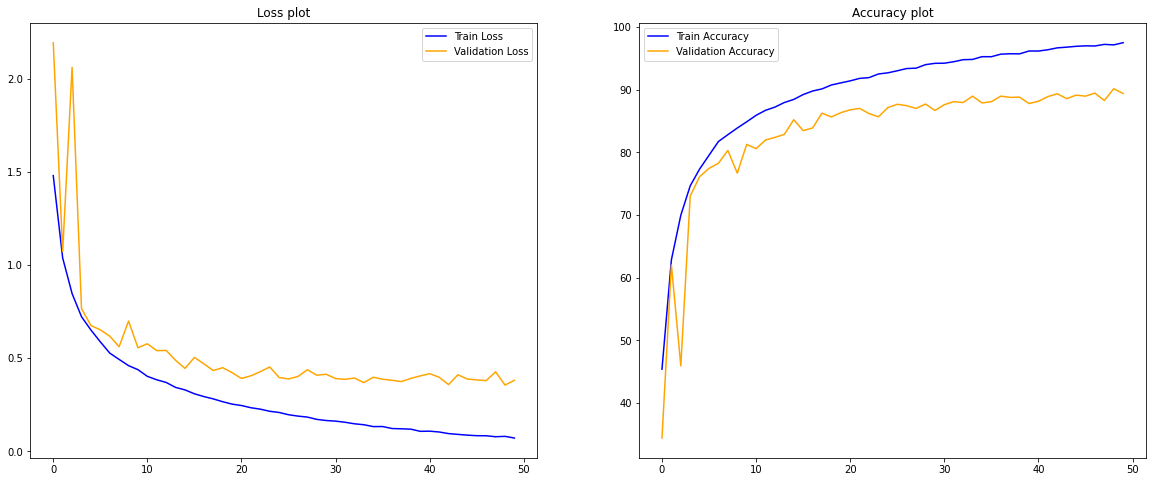

In [ ]:
fig = plt.figure(figsize=(20, 8))

fig.add_subplot(1, 2, 1)
plt.plot(train_losses, color = 'blue', label = 'Train Loss')
plt.plot(eval_losses, color = 'orange', label = 'Validation Loss')
plt.title('Loss plot')
plt.legend(loc ='upper right')

fig.add_subplot(1, 2, 2)
plt.plot(train_accuracies, color = 'blue', label = 'Train Accuracy')
plt.plot(eval_accuracies, color = 'orange', label = 'Validation Accuracy')
plt.title('Accuracy plot')
plt.legend(loc='upper left')

## Evaluation

Test your trained model (using the Test Dataloader that you have). Our goal is to reach an accuracy above `90%`

In [ ]:
eval_epoch(net, criterion, [], [], Testloader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 10/10 [00:03<00:00,  3.27it/s]

evaluation loss: 0.3970634937286377, evaluation accuracy: 90.06


## Visualize incorrectly predicted samples from testset

Visualize *24* random images from testset that are incorrectly predicted by the model

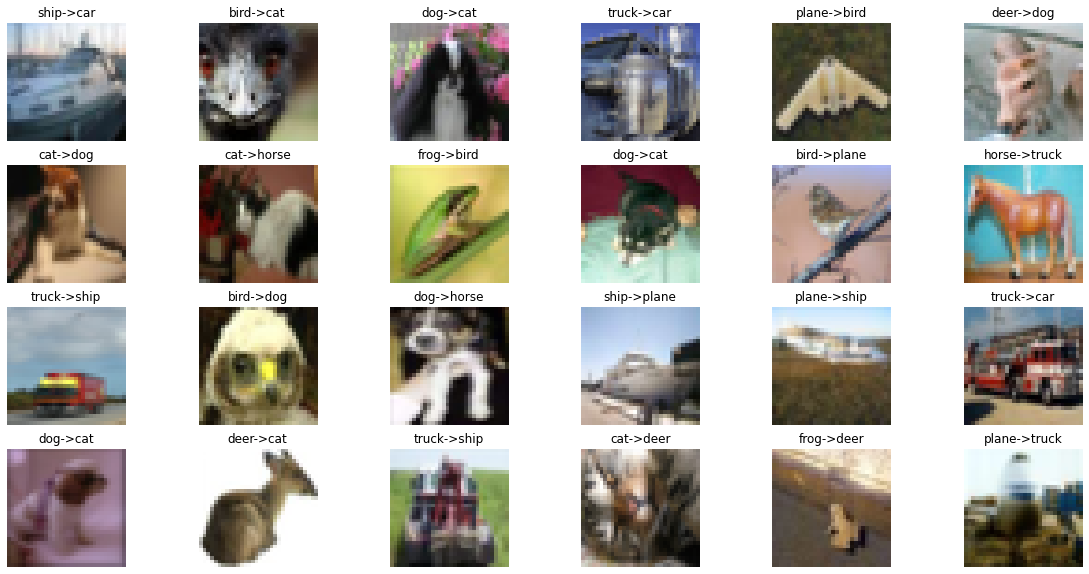

In [ ]:
image_list = []
i = 0
while len(image_list) < 25:
  img, label = Testset[i]
  x = img.unsqueeze(0)
  x = x.to(device)
  y = net(x)
  _, predict = y.max(1)
  if predict != label:
    image_list.append([img, label, predict])
  i += 1

fig = plt.figure(figsize = (20, 10))
for i in range(24):
  fig.add_subplot(4, 6, i + 1)
  plt.imshow(image_list[i][0].permute(1, 2, 0).numpy())
  plt.title(str(classes[image_list[i][1]]) + '->' + str(classes[image_list[i][2]]))
  plt.axis('off')



## Exploring the feature space

### Calculate the feature space for all training samples

You have trained and evaluated your model. Now, for each sample in the trainset, calculate it's "feature space" discussed in the model section. The result of this section should be a tensor of size `(50000, N)` saved in a variable (for later usage)

- **Hint 1:** define a tensor with dimension `(50000, N)` where *50000* is the size of the trainset and *N* is the dimension of the feature space

- **Hint 2:** Pay attension to the `shuffle` attribute of your train dataloader (If needed)

In [ ]:
device = 'cpu'

In [ ]:
T = Trainset + Valset
dataloader = torch.utils.data.DataLoader(T, batch_size = 1, shuffle = False, num_workers = 1)

feature_space = torch.zeros(50000, 512)
net.to(device)
net.eval()
for i, (img, label) in enumerate(dataloader):
  vector = net.get_feature_vector(img.to(device))
  vector = vector.detach()
  feature_space[i-1] = vector

feature_space.shape

torch.Size([50000, 512])

### K Nearest Neighbor in feature space

You already have calculated the feature spaces for trainset ($S$) in the previous section

1. Get 5 random samples from testset which are correctly predicted by the model. 
2. for each sample, calculate it's "feature space" ($X$)
3. for each sample, calculate it's *5* nearest neighbors in "feature space" in the trainset (by comparing $X$ to each row in $S$) and visualize them

**Note:** Your visualization should be something like the below picture

**Hint:** For finding the nearest neighbors in the feature space you can use `torch.linalg.norm` and `torch.topk`

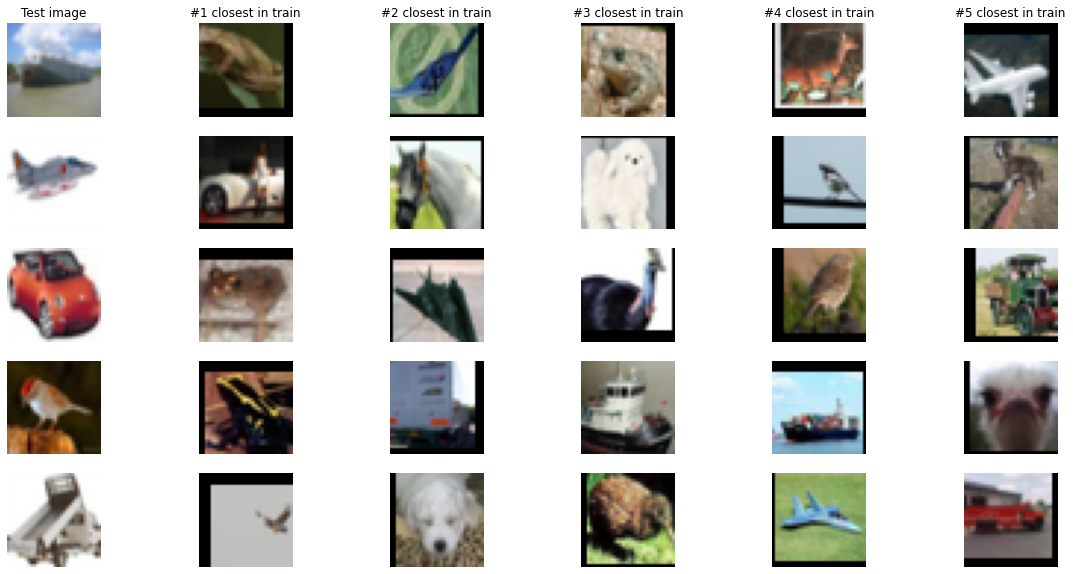

In [ ]:
import random

def get_nearest(feature, feature_vector):
  difference = feature - feature_vector
  normed = torch.linalg.norm(difference, dim = 1)
  results = torch.topk(normed, 5, largest = False)
  return results.indices[0:]

test_samples = []
while len(test_samples) < 5:
  index = random.randint(0, len(Testset) - 1)
  img, label = Testset[index]
  x = img.to(device)
  x = x.unsqueeze(0)
  y = net(x)
  _, predict = y.max(1)
  if (predict == label):
    test_samples.append(img)

fig = plt.figure(figsize = (20, 10))

for i in range(len(test_samples)):
  vector = net.get_feature_vector(test_samples[i].unsqueeze(0))
  indexes = get_nearest(feature_space, vector)
  fig.add_subplot(5, 6, 6 * i + 1)
  plt.imshow(test_samples[i].permute(1, 2, 0).numpy())
  plt.axis('off')
  if (i == 0):
    plt.title('Test image')

  for j in range(1, 6):
    fig.add_subplot(5, 6, 6 * i + 1 + j)
    
    plt.imshow(T[indexes[j-1]][0].permute(1, 2, 0).numpy())
    plt.axis('off')
    if (i == 0):
      plt.title(f'#{j} closest in train')


### TSNE 

1. Sample $M$ ($2000$ would be enought) random samples from the trainset feature space (calculated in the above sections) 
2. Now you a vector of size `(M, N)` where $N$ is the dimension of the feature space
3. Using TSNE reduce $N$ to $2$ (Now you have a vector of size `(M, 2)`)
4. Print the shape of the output

**Hint:** You can use `sklearn.manifold.TSNE`

In [ ]:
from sklearn.manifold import TSNE
random_indexes = torch.randperm(len(feature_space))
selected_indexes = random_indexes[:2000]
selected_vectors = feature_space[selected_indexes]
y = net.fc(selected_vectors)
_, class_predict = y.max(1)
class_predict = class_predict.numpy()

model = TSNE(n_components = 2, random_state = 0, learning_rate = 'auto', init = 'random')
reduced_vectors = model.fit_transform(selected_vectors)
reduced_vectors.shape

(2000, 2)

Visualize the points in a 2D plane (Set color of each point based on it's class)

**Notice:** Your visualization should be something like the below image

**Hint:** Use `plt.scatter(x, y, c=labels)`

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Unrecognized location 'upper-right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  


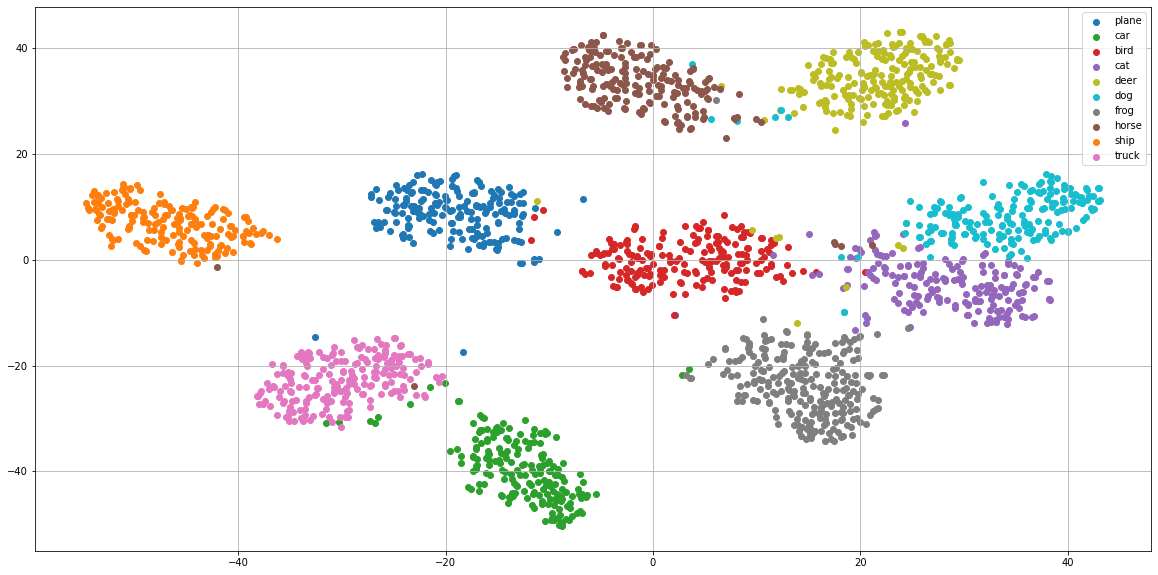

In [ ]:
classes_indexes = {i: [] for i in range(10)}

zip_data = list(zip(reduced_vectors, class_predict))

colors = ['tab:blue', 'tab:green', 'tab:red', 'tab:purple', 'tab:olive', 'tab:cyan', 'tab:grey', 'tab:brown', 'tab:orange', 'tab:pink']

fig, ax = plt.subplots(figsize = (20, 10))
for i in range(10):
  color = colors[i]
  clas = classes[i]
  data = torch.tensor([x[0] for x in zip_data if x[1] == i])
  ax.scatter(data[:, 0], data[:, 1], c = color, label = clas)

ax.legend(loc = 'upper-right')
ax.grid(True)

plt.show()

# CIFAR10 Colorization

In this part of the assignment, we want to do an image colorization task using PyTorch on CIFAR10 dataset. We want to train a model that colors  a black-and-white image.

## Import Libraries

Import needed libraries

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Custom Dataset

Define a custom dataset class by extensing `torch.utils.data.Dataset`

**Notice:** your dataset should output two things: black-and-white image and the RGB image

**Hint:** You don't have to reinvent the wheel. Your class should just be a wrapper for CIFAR10 dataset

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
class custom_dataset(torch.utils.data.Dataset):
    def __init__(self):
        train_set = torchvision.datasets.CIFAR10(root = './data', download = True, train = True, transform = transforms.ToTensor())
        test_set = torchvision.datasets.CIFAR10(root = './data', download = True, train = False, transform = transforms.ToTensor())
        
        rgb_set = []
        gray_set = []
        transformer = transforms.Grayscale(1)
        for image, label in train_set:
            rgb_set.append(image)
            gray_set.append(transformer(image))
            
        self.rgb_train_set, self.rgb_eval_set, self.gray_train_set, self.gray_eval_set = train_test_split(rgb_set, gray_set, train_size = 0.9)
        
        self.rgb_test_set = []
        self.gray_test_set = []
        for image, label in test_set:
            self.rgb_test_set.append(image)
            self.gray_test_set.append(transformer(image))
        
    def __len__(self):
        return len(self.train_set)
    
    def __get_item__(self, idx):
        return self.train_set[idx]
        

## Transforms & Dataset & Dataloader

**Notice:** Use your defined custom dataset class for defining the datasets

In [ ]:
dataset = custom_dataset()

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Dataset Visualization

Visualize your dataset (black-and-white image along with the RGB image) by sampling from your trainset

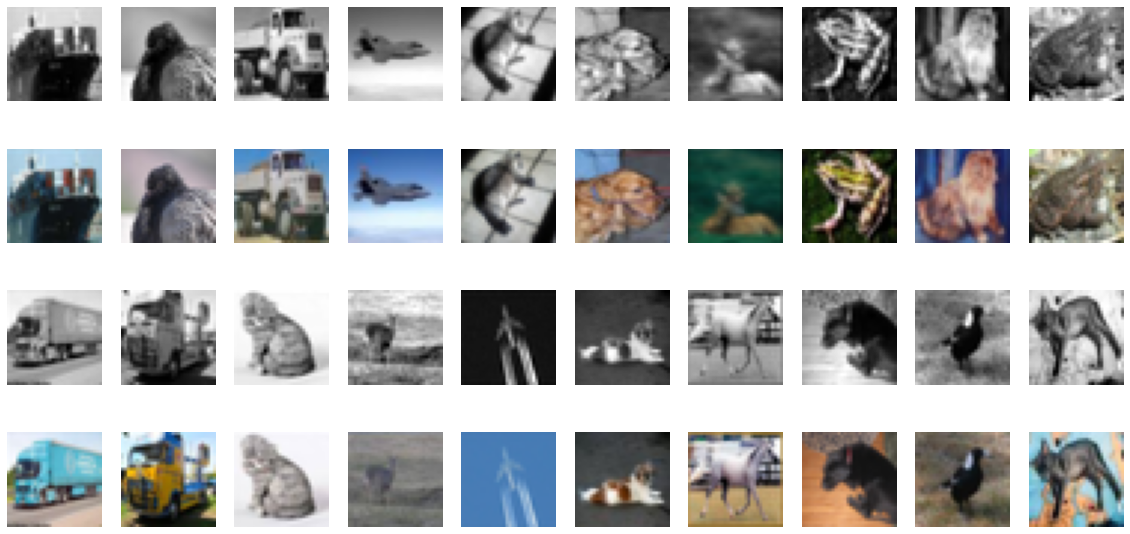

In [ ]:
fig = plt.figure(figsize = (20, 10))

for i in range(10):
    img = dataset.gray_train_set[i]
    fig.add_subplot(4, 10, i + 1)
    img1 = img[-1, :, :]
    plt.imshow(img1.numpy(), cmap = plt.get_cmap('gray'))
    plt.axis(False)
    plt.grid(True)
    
for i in range(10):
    img = dataset.rgb_train_set[i]
    fig.add_subplot(4, 10, i + 11)
    plt.imshow(img.permute(1, 2, 0).numpy())
    plt.axis(False)
    plt.grid(True)
    
for i in range(10, 20):
    img = dataset.gray_train_set[i]
    fig.add_subplot(4, 10, i + 11)
    img1 = img[-1, :, :]
    plt.imshow(img1.numpy(), cmap = plt.get_cmap('gray'))
    plt.axis(False)
    plt.grid(True)
    
for i in range(10, 20):
    img = dataset.rgb_train_set[i]
    fig.add_subplot(4, 10, i + 21)
    plt.imshow(img.permute(1, 2, 0).numpy())
    plt.axis(False)
    plt.grid(True)
plt.show()

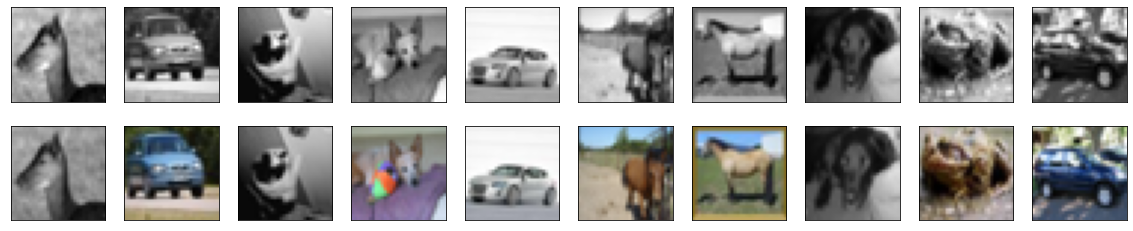

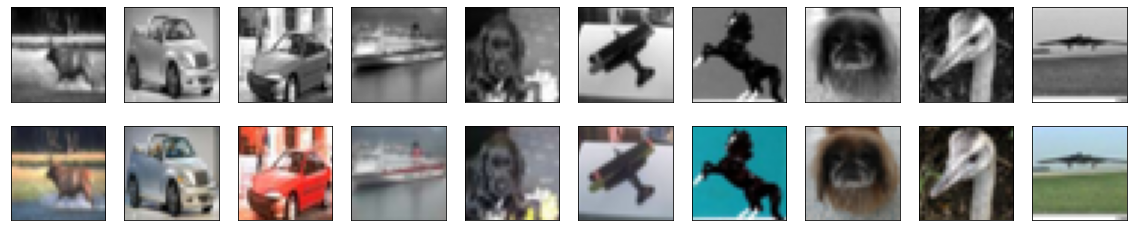

## Model

Define your model here (Input: black-and-white image, Output: RGB image)

**Hint:** You can implement an autoencoder that does the colorization task for you. UNet could be a viable option 

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 64, 3, 1, 1)
        self.batch1 = nn.BatchNorm2d(64)
        self.relu1 = nn.LeakyReLU(0.2)
        
        
        self.conv2 = nn.Conv2d(64, 64, 4, 2, 1)
        self.batch2 = nn.BatchNorm2d(64)
        self.relu2 = nn.LeakyReLU(0.2)
        
        self.conv3 = nn.Conv2d(64, 128, 4, 2, 1)
        self.batch3 = nn.BatchNorm2d(128)
        self.relu3 = nn.LeakyReLU(0.2)
        
        self.conv4 = nn.Conv2d(128, 256, 4, 2, 1)
        self.batch4 = nn.BatchNorm2d(256)
        self.relu4 = nn.LeakyReLU(0.2)
        
        self.conv5 = nn.Conv2d(256, 512, 4, 2, 1)
        self.batch5 = nn.BatchNorm2d(512)
        self.relu5 = nn.LeakyReLU(0.2)
        
        self.conv6 = nn.ConvTranspose2d(512, 512, 4, 2, 1)
        self.batch6 = nn.BatchNorm2d(512)
        self.relu6 = nn.LeakyReLU(0.2)
        
        self.conv7 = nn.ConvTranspose2d(512, 256, 4, 2, 1)
        self.batch7 = nn.BatchNorm2d(256)
        self.relu7 = nn.LeakyReLU(0.2)
        
        self.conv8 = nn.ConvTranspose2d(256, 128, 4, 2, 1)
        self.batch8 = nn.BatchNorm2d(128)
        self.relu8 = nn.LeakyReLU(0.2)
        
        self.conv9 = nn.ConvTranspose2d(128, 64, 4, 2, 1)
        self.batch9 = nn.BatchNorm2d(64)
        self.relu9 = nn.LeakyReLU(0.2)
        
        self.conv10 = nn.ConvTranspose2d(64, 64, 4, 2, 1)
        self.batch10 = nn.BatchNorm2d(64)
        self.relu10 = nn.LeakyReLU(0.2)
        
        self.conv11 = nn.Conv2d(64, 3, 4, 2, 1)
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.batch1(x)
        x = self.relu1(x)
        
        
        x = self.conv2(x)
        x = self.batch2(x)
        x = self.relu2(x)
        
        
        x = self.conv3(x)
        x = self.batch3(x)
        x = self.relu3(x)
        
        
        x = self.conv4(x)
        x = self.batch4(x)
        x = self.relu4(x)
        
        
        x = self.conv5(x)
        x = self.batch5(x)
        x = self.relu5(x)
        
        
        x = self.conv6(x)
        x = self.batch6(x)
        x = self.relu6(x)
        
        
        x = self.conv7(x)
        x = self.batch7(x)
        x = self.relu7(x)
        
        
        x = self.conv8(x)
        x = self.batch8(x)
        x = self.relu8(x)
        
        
        x = self.conv9(x)
        x = self.batch9(x)
        x = self.relu9(x)
        
        
        x = self.conv10(x)
        x = self.batch10(x)
        x = self.relu10(x)
        
        
        x = self.conv11(x)
        
        return x
        

In [ ]:
net = UNet()
net.to(device)

UNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): LeakyReLU(negative_slope=0.2)
  (conv2): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (batch2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): LeakyReLU(negative_slope=0.2)
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (batch3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): LeakyReLU(negative_slope=0.2)
  (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (batch4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): LeakyReLU(negative_slope=0.2)
  (conv5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (batch5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, trac

## Train

Train your model

Tasks:
- [ ] Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Validation loss
- [ ] save train/validation loss (of each epoch) in an array for later usage

In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingLR
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
scheduler = CosineAnnealingLR(optimizer, T_max = 200)

In [ ]:
train_dataloader = torch.utils.data.DataLoader(list(zip(dataset.rgb_train_set, dataset.gray_train_set)), batch_size = 128, shuffle = False, num_workers = 2)
eval_dataloader = torch.utils.data.DataLoader(list(zip(dataset.rgb_eval_set, dataset.gray_eval_set)), batch_size = 128, shuffle = False, num_workers = 2)


In [ ]:
import tqdm

def train_epoch(model, criterion, optimizer, train_losses, dataloader):
    model.train()
    
    running_loss = 0
    
    
    with tqdm.tqdm(enumerate(dataloader),  total = len(dataloader)) as pbar:
        for i, (rgb, gray) in pbar:
            gray_images = gray.to(device)
            rgb_images = rgb.to(device)
        
            optimizer.zero_grad()
        
            result = model(gray_images)
            
            loss = criterion(result, rgb_images)
            loss.backward()
            optimizer.step()
        
            running_loss += loss.item()
            
        
    train_loss = running_loss / len(dataloader)
    
    train_losses.append(train_loss)
    
    print(f'train loss: {train_loss}')

In [ ]:
def eval_epoch(model, criterion, eval_losses, dataloader):
    model.eval()
    
    running_loss = 0
    
    
    with torch.no_grad(), tqdm.tqdm(enumerate(dataloader),  total = len(dataloader)) as pbar:
        for i, (rgb, gray) in pbar:
            gray_images = gray.to(device)
            rgb_images = rgb.to(device)
        
            result = model(gray_images)
            
            loss = criterion(result, rgb_images)
            
            running_loss += loss.item()
            
        
    eval_loss = running_loss / len(dataloader)
    
    eval_losses.append(eval_loss)
    
    print(f'evaluation loss: {eval_loss}')

In [ ]:
epochs = 200
train_losses = []
eval_losses = []
for i in range(epochs):
    print(f'Epoch: {i + 1}')
    train_epoch(net, criterion, optimizer, train_losses, train_dataloader)
    eval_epoch(net, criterion, eval_losses, eval_dataloader)
    scheduler.step()

Epoch: 1


100%|██████████| 352/352 [01:08<00:00,  5.15it/s]

train loss: 0.02972543442261998



100%|██████████| 40/40 [00:02<00:00, 17.13it/s]

evaluation loss: 0.015784794371575116
Epoch: 2



100%|██████████| 352/352 [01:02<00:00,  5.66it/s]

train loss: 0.01405845699165101



100%|██████████| 40/40 [00:02<00:00, 16.57it/s]

evaluation loss: 0.012460529408417641
Epoch: 3



100%|██████████| 352/352 [01:02<00:00,  5.62it/s]

train loss: 0.011387487447460775



100%|██████████| 40/40 [00:02<00:00, 16.82it/s]

evaluation loss: 0.010034326370805502
Epoch: 4



100%|██████████| 352/352 [01:03<00:00,  5.59it/s]

train loss: 0.009933232360212556



100%|██████████| 40/40 [00:02<00:00, 16.67it/s]

evaluation loss: 0.009133822261355817
Epoch: 5



100%|██████████| 352/352 [01:03<00:00,  5.58it/s]

train loss: 0.009076982538152317



100%|██████████| 40/40 [00:02<00:00, 16.64it/s]

evaluation loss: 0.009538348868954927
Epoch: 6



100%|██████████| 352/352 [01:03<00:00,  5.58it/s]

train loss: 0.008492842365574854



100%|██████████| 40/40 [00:02<00:00, 16.77it/s]

evaluation loss: 0.008358609420247376
Epoch: 7



100%|██████████| 352/352 [01:02<00:00,  5.59it/s]

train loss: 0.008057665975436314



100%|██████████| 40/40 [00:02<00:00, 16.71it/s]

evaluation loss: 0.008160936285275967
Epoch: 8



100%|██████████| 352/352 [01:02<00:00,  5.59it/s]

train loss: 0.007759228094734929



100%|██████████| 40/40 [00:02<00:00, 16.80it/s]

evaluation loss: 0.008132465148810298
Epoch: 9



100%|██████████| 352/352 [01:02<00:00,  5.59it/s]

train loss: 0.007495088599336503



100%|██████████| 40/40 [00:02<00:00, 16.74it/s]

evaluation loss: 0.008072006294969469
Epoch: 10



100%|██████████| 352/352 [01:03<00:00,  5.58it/s]

train loss: 0.007223163617626679



100%|██████████| 40/40 [00:02<00:00, 16.72it/s]

evaluation loss: 0.007897508214227855
Epoch: 11



100%|██████████| 352/352 [01:03<00:00,  5.59it/s]

train loss: 0.006940852448513562



100%|██████████| 40/40 [00:02<00:00, 16.71it/s]

evaluation loss: 0.007866995851509273
Epoch: 12



100%|██████████| 352/352 [01:03<00:00,  5.58it/s]

train loss: 0.006657197363727557



100%|██████████| 40/40 [00:02<00:00, 16.68it/s]

evaluation loss: 0.00770960811059922
Epoch: 13



100%|██████████| 352/352 [01:03<00:00,  5.58it/s]

train loss: 0.006385635099088011



100%|██████████| 40/40 [00:02<00:00, 16.71it/s]

evaluation loss: 0.007762249850202352
Epoch: 14



100%|██████████| 352/352 [01:03<00:00,  5.59it/s]

train loss: 0.006106882587614978



100%|██████████| 40/40 [00:02<00:00, 16.78it/s]

evaluation loss: 0.007835869293194265
Epoch: 15



100%|██████████| 352/352 [01:03<00:00,  5.58it/s]

train loss: 0.0058837805170862175



100%|██████████| 40/40 [00:02<00:00, 16.78it/s]

evaluation loss: 0.007941745186690241
Epoch: 16



100%|██████████| 352/352 [01:02<00:00,  5.59it/s]

train loss: 0.005763598106568679



100%|██████████| 40/40 [00:02<00:00, 16.72it/s]

evaluation loss: 0.008326582843437791
Epoch: 17



100%|██████████| 352/352 [01:03<00:00,  5.58it/s]

train loss: 0.005545973592564802



100%|██████████| 40/40 [00:02<00:00, 16.59it/s]

evaluation loss: 0.009387743973638863
Epoch: 18



100%|██████████| 352/352 [01:02<00:00,  5.59it/s]

train loss: 0.005270080834055658



100%|██████████| 40/40 [00:02<00:00, 16.63it/s]

evaluation loss: 0.008943301881663502
Epoch: 19



100%|██████████| 352/352 [01:02<00:00,  5.59it/s]

train loss: 0.00506528582429217



100%|██████████| 40/40 [00:02<00:00, 16.81it/s]

evaluation loss: 0.008456349256448448
Epoch: 20



100%|██████████| 352/352 [01:02<00:00,  5.59it/s]

train loss: 0.004903636172292119



100%|██████████| 40/40 [00:02<00:00, 16.75it/s]

evaluation loss: 0.008338677952997387
Epoch: 21



100%|██████████| 352/352 [01:02<00:00,  5.59it/s]

train loss: 0.004764271909318102



100%|██████████| 40/40 [00:02<00:00, 16.78it/s]

evaluation loss: 0.00897968711797148
Epoch: 22



100%|██████████| 352/352 [01:03<00:00,  5.58it/s]

train loss: 0.004639079575347502



100%|██████████| 40/40 [00:02<00:00, 16.64it/s]

evaluation loss: 0.008678626245819032
Epoch: 23



100%|██████████| 352/352 [01:02<00:00,  5.59it/s]

train loss: 0.004473918572660874



100%|██████████| 40/40 [00:02<00:00, 16.70it/s]

evaluation loss: 0.00840727259637788
Epoch: 24



100%|██████████| 352/352 [01:02<00:00,  5.60it/s]

train loss: 0.0043234164305348795



100%|██████████| 40/40 [00:02<00:00, 16.85it/s]

evaluation loss: 0.008688917884137481
Epoch: 25



100%|██████████| 352/352 [01:02<00:00,  5.59it/s]

train loss: 0.004167756850868252



100%|██████████| 40/40 [00:02<00:00, 16.87it/s]

evaluation loss: 0.008840289281215519
Epoch: 26



100%|██████████| 352/352 [01:02<00:00,  5.59it/s]

train loss: 0.004048186683080116



100%|██████████| 40/40 [00:02<00:00, 16.82it/s]

evaluation loss: 0.00918186028720811
Epoch: 27



100%|██████████| 352/352 [01:03<00:00,  5.59it/s]

train loss: 0.003940600857524921



100%|██████████| 40/40 [00:02<00:00, 16.80it/s]

evaluation loss: 0.008977696241345257
Epoch: 28



100%|██████████| 352/352 [01:02<00:00,  5.59it/s]

train loss: 0.0038133600517705254



100%|██████████| 40/40 [00:02<00:00, 16.70it/s]

evaluation loss: 0.008012956951279192
Epoch: 29



100%|██████████| 352/352 [01:03<00:00,  5.58it/s]

train loss: 0.003712879857630469



100%|██████████| 40/40 [00:02<00:00, 16.73it/s]

evaluation loss: 0.007889687654096634
Epoch: 30



100%|██████████| 352/352 [01:03<00:00,  5.58it/s]

train loss: 0.0036109160798580638



100%|██████████| 40/40 [00:02<00:00, 16.72it/s]

evaluation loss: 0.007697079435456544
Epoch: 31



100%|██████████| 352/352 [01:02<00:00,  5.59it/s]

train loss: 0.0035169771733556195



100%|██████████| 40/40 [00:02<00:00, 16.72it/s]

evaluation loss: 0.008618977840524168
Epoch: 32



100%|██████████| 352/352 [01:03<00:00,  5.58it/s]

train loss: 0.003408510448934976



100%|██████████| 40/40 [00:02<00:00, 16.67it/s]

evaluation loss: 0.00788189220475033
Epoch: 33



100%|██████████| 352/352 [01:03<00:00,  5.58it/s]

train loss: 0.003308025736425241



100%|██████████| 40/40 [00:02<00:00, 16.87it/s]

evaluation loss: 0.008010159083642065
Epoch: 34



100%|██████████| 352/352 [01:03<00:00,  5.58it/s]

train loss: 0.0032609336902334526



100%|██████████| 40/40 [00:02<00:00, 16.62it/s]

evaluation loss: 0.007437251752708107
Epoch: 35



100%|██████████| 352/352 [01:03<00:00,  5.58it/s]

train loss: 0.0033704694009925747



100%|██████████| 40/40 [00:02<00:00, 16.73it/s]

evaluation loss: 0.007550152653129772
Epoch: 36



100%|██████████| 352/352 [01:03<00:00,  5.58it/s]

train loss: 0.0033690458817132326



100%|██████████| 40/40 [00:02<00:00, 16.64it/s]

evaluation loss: 0.007392257818719372
Epoch: 37



100%|██████████| 352/352 [01:03<00:00,  5.57it/s]

train loss: 0.0032911860054644585



100%|██████████| 40/40 [00:02<00:00, 16.64it/s]

evaluation loss: 0.007289893086999654
Epoch: 38



100%|██████████| 352/352 [01:03<00:00,  5.58it/s]

train loss: 0.0031984146427765318



100%|██████████| 40/40 [00:02<00:00, 16.73it/s]

evaluation loss: 0.007274797797435895
Epoch: 39



100%|██████████| 352/352 [01:02<00:00,  5.59it/s]

train loss: 0.003157453913776077



100%|██████████| 40/40 [00:02<00:00, 16.70it/s]

evaluation loss: 0.00801211625803262
Epoch: 40



100%|██████████| 352/352 [01:03<00:00,  5.58it/s]

train loss: 0.0031745247946343047



100%|██████████| 40/40 [00:02<00:00, 16.74it/s]

evaluation loss: 0.009292462724260986
Epoch: 41



100%|██████████| 352/352 [01:03<00:00,  5.58it/s]

train loss: 0.003042253465206489



100%|██████████| 40/40 [00:02<00:00, 16.78it/s]

evaluation loss: 0.00784273857716471
Epoch: 42



100%|██████████| 352/352 [01:03<00:00,  5.57it/s]

train loss: 0.0029355640316763047



100%|██████████| 40/40 [00:02<00:00, 16.77it/s]

evaluation loss: 0.007427816221024841
Epoch: 43



100%|██████████| 352/352 [01:02<00:00,  5.59it/s]

train loss: 0.0029294112127073195



100%|██████████| 40/40 [00:02<00:00, 16.77it/s]

evaluation loss: 0.007978748716413974
Epoch: 44



100%|██████████| 352/352 [01:02<00:00,  5.59it/s]

train loss: 0.0029182471950083377



100%|██████████| 40/40 [00:02<00:00, 16.72it/s]

evaluation loss: 0.008059353684075177
Epoch: 45



100%|██████████| 352/352 [01:02<00:00,  5.59it/s]

train loss: 0.002899666093898387



100%|██████████| 40/40 [00:02<00:00, 16.75it/s]

evaluation loss: 0.008021771686617284
Epoch: 46



100%|██████████| 352/352 [01:02<00:00,  5.59it/s]

train loss: 0.002825906658968465



100%|██████████| 40/40 [00:02<00:00, 16.77it/s]

evaluation loss: 0.008190778526477515
Epoch: 47



100%|██████████| 352/352 [01:02<00:00,  5.59it/s]

train loss: 0.002762185114658099



100%|██████████| 40/40 [00:02<00:00, 16.76it/s]

evaluation loss: 0.0074770787032321095
Epoch: 48



100%|██████████| 352/352 [01:02<00:00,  5.59it/s]

train loss: 0.0027813986281134103



100%|██████████| 40/40 [00:02<00:00, 16.87it/s]

evaluation loss: 0.007612789119593799
Epoch: 49



100%|██████████| 352/352 [01:03<00:00,  5.58it/s]

train loss: 0.002798653855941004



100%|██████████| 40/40 [00:02<00:00, 16.74it/s]

evaluation loss: 0.007713838818017393
Epoch: 50



100%|██████████| 352/352 [01:03<00:00,  5.58it/s]

train loss: 0.002731814685499888



100%|██████████| 40/40 [00:02<00:00, 16.74it/s]

evaluation loss: 0.007432969787623733
Epoch: 51



100%|██████████| 352/352 [01:02<00:00,  5.59it/s]

train loss: 0.002647991648700554



100%|██████████| 40/40 [00:02<00:00, 16.70it/s]

evaluation loss: 0.00728253232082352
Epoch: 52



100%|██████████| 352/352 [01:03<00:00,  5.58it/s]

train loss: 0.0025882062903044493



100%|██████████| 40/40 [00:02<00:00, 16.75it/s]

evaluation loss: 0.007080153591232374
Epoch: 53



100%|██████████| 352/352 [01:03<00:00,  5.58it/s]

train loss: 0.002634837379446253



100%|██████████| 40/40 [00:02<00:00, 16.72it/s]

evaluation loss: 0.007515379932010546
Epoch: 54



100%|██████████| 352/352 [01:02<00:00,  5.59it/s]

train loss: 0.002709044088657141



100%|██████████| 40/40 [00:02<00:00, 16.75it/s]

evaluation loss: 0.007614556688349694
Epoch: 55



100%|██████████| 352/352 [01:02<00:00,  5.59it/s]

train loss: 0.0026981837819965385



100%|██████████| 40/40 [00:02<00:00, 16.54it/s]

evaluation loss: 0.007452616025693715
Epoch: 56



100%|██████████| 352/352 [01:03<00:00,  5.58it/s]

train loss: 0.0025126781871552917



100%|██████████| 40/40 [00:02<00:00, 16.68it/s]

evaluation loss: 0.0075982733746059235
Epoch: 57



100%|██████████| 352/352 [01:03<00:00,  5.58it/s]

train loss: 0.0023469167717848904



100%|██████████| 40/40 [00:02<00:00, 16.78it/s]

evaluation loss: 0.007306367531418801
Epoch: 58



100%|██████████| 352/352 [01:02<00:00,  5.59it/s]

train loss: 0.002286102775542531



100%|██████████| 40/40 [00:02<00:00, 16.79it/s]

evaluation loss: 0.007520262792240828
Epoch: 59



100%|██████████| 352/352 [01:03<00:00,  5.58it/s]

train loss: 0.002276375261069254



100%|██████████| 40/40 [00:02<00:00, 16.78it/s]

evaluation loss: 0.0074526299722492695
Epoch: 60



100%|██████████| 352/352 [01:03<00:00,  5.58it/s]

train loss: 0.0023697642219221134



100%|██████████| 40/40 [00:02<00:00, 16.84it/s]

evaluation loss: 0.007198432611767202
Epoch: 61



100%|██████████| 352/352 [01:02<00:00,  5.59it/s]

train loss: 0.0024000193092929708



100%|██████████| 40/40 [00:02<00:00, 16.79it/s]

evaluation loss: 0.007075525808613747
Epoch: 62



100%|██████████| 352/352 [01:02<00:00,  5.60it/s]

train loss: 0.002333703829208389



100%|██████████| 40/40 [00:02<00:00, 16.78it/s]

evaluation loss: 0.007025212503504008
Epoch: 63



100%|██████████| 352/352 [01:03<00:00,  5.58it/s]

train loss: 0.0022459299775205595



100%|██████████| 40/40 [00:02<00:00, 16.73it/s]

evaluation loss: 0.007140710984822362
Epoch: 64



100%|██████████| 352/352 [01:02<00:00,  5.59it/s]

train loss: 0.002306283312050668



100%|██████████| 40/40 [00:02<00:00, 16.75it/s]

evaluation loss: 0.00723725552088581
Epoch: 65



100%|██████████| 352/352 [01:03<00:00,  5.58it/s]

train loss: 0.002377093411103653



100%|██████████| 40/40 [00:02<00:00, 16.76it/s]

evaluation loss: 0.0072407624335028235
Epoch: 66



100%|██████████| 352/352 [01:02<00:00,  5.60it/s]

train loss: 0.0022613253495364916



100%|██████████| 40/40 [00:02<00:00, 16.77it/s]

evaluation loss: 0.0072215049061924216
Epoch: 67



100%|██████████| 352/352 [01:02<00:00,  5.59it/s]

train loss: 0.002148361724473282



100%|██████████| 40/40 [00:02<00:00, 16.83it/s]

evaluation loss: 0.007272180652944371
Epoch: 68



100%|██████████| 352/352 [01:02<00:00,  5.59it/s]

train loss: 0.0020981232036402534



100%|██████████| 40/40 [00:02<00:00, 16.78it/s]

evaluation loss: 0.007161516201449558
Epoch: 69



100%|██████████| 352/352 [01:03<00:00,  5.59it/s]

train loss: 0.002100583682807734



100%|██████████| 40/40 [00:02<00:00, 16.81it/s]

evaluation loss: 0.007049752242164686
Epoch: 70



100%|██████████| 352/352 [01:03<00:00,  5.59it/s]

train loss: 0.0021222914666313127



100%|██████████| 40/40 [00:02<00:00, 16.80it/s]

evaluation loss: 0.0071454964810982345
Epoch: 71



100%|██████████| 352/352 [01:02<00:00,  5.59it/s]

train loss: 0.0022005386430960657



100%|██████████| 40/40 [00:02<00:00, 16.63it/s]

evaluation loss: 0.0070137183472979816
Epoch: 72



100%|██████████| 352/352 [01:03<00:00,  5.59it/s]

train loss: 0.002193732437841721



100%|██████████| 40/40 [00:02<00:00, 16.66it/s]

evaluation loss: 0.007009553053649142
Epoch: 73



100%|██████████| 352/352 [01:03<00:00,  5.58it/s]

train loss: 0.002106674138882557



100%|██████████| 40/40 [00:02<00:00, 16.58it/s]

evaluation loss: 0.006976404669694602
Epoch: 74



100%|██████████| 352/352 [01:02<00:00,  5.59it/s]

train loss: 0.002020505959080765



100%|██████████| 40/40 [00:02<00:00, 16.87it/s]

evaluation loss: 0.006861213687807321
Epoch: 75



100%|██████████| 352/352 [01:03<00:00,  5.58it/s]

train loss: 0.0019868485221443484



100%|██████████| 40/40 [00:02<00:00, 16.61it/s]

evaluation loss: 0.006877752381842584
Epoch: 76



100%|██████████| 352/352 [01:03<00:00,  5.58it/s]

train loss: 0.001987512706942983



100%|██████████| 40/40 [00:02<00:00, 16.84it/s]

evaluation loss: 0.007179549831198529
Epoch: 77



100%|██████████| 352/352 [01:02<00:00,  5.60it/s]

train loss: 0.001969115597603377



100%|██████████| 40/40 [00:02<00:00, 16.72it/s]

evaluation loss: 0.009724129934329539
Epoch: 78



100%|██████████| 352/352 [01:03<00:00,  5.58it/s]

train loss: 0.0019243520847257141



100%|██████████| 40/40 [00:02<00:00, 16.59it/s]

evaluation loss: 0.007537912460975349
Epoch: 79



100%|██████████| 352/352 [01:03<00:00,  5.58it/s]

train loss: 0.0018803415984042328



100%|██████████| 40/40 [00:02<00:00, 16.70it/s]

evaluation loss: 0.0071806734311394395
Epoch: 80



100%|██████████| 352/352 [01:02<00:00,  5.60it/s]

train loss: 0.0018583329080932097



100%|██████████| 40/40 [00:02<00:00, 16.69it/s]

evaluation loss: 0.007253373379353434
Epoch: 81



100%|██████████| 352/352 [01:03<00:00,  5.58it/s]

train loss: 0.0018826130323180803



100%|██████████| 40/40 [00:02<00:00, 16.76it/s]

evaluation loss: 0.007295788498595357
Epoch: 82



100%|██████████| 352/352 [01:02<00:00,  5.59it/s]

train loss: 0.0019817784080011984



100%|██████████| 40/40 [00:02<00:00, 16.78it/s]

evaluation loss: 0.007100333465496078
Epoch: 83



100%|██████████| 352/352 [01:03<00:00,  5.58it/s]

train loss: 0.002086337298599326



100%|██████████| 40/40 [00:02<00:00, 16.74it/s]

evaluation loss: 0.0070279974723234774
Epoch: 84



100%|██████████| 352/352 [01:03<00:00,  5.58it/s]

train loss: 0.002021817188175522



100%|██████████| 40/40 [00:02<00:00, 16.72it/s]

evaluation loss: 0.006901280378224328
Epoch: 85



100%|██████████| 352/352 [01:03<00:00,  5.58it/s]

train loss: 0.0018988423587209334



100%|██████████| 40/40 [00:02<00:00, 16.72it/s]

evaluation loss: 0.0067697081482037905
Epoch: 86



100%|██████████| 352/352 [01:02<00:00,  5.59it/s]

train loss: 0.0017786053636386482



100%|██████████| 40/40 [00:02<00:00, 16.83it/s]

evaluation loss: 0.006770019268151373
Epoch: 87



100%|██████████| 352/352 [01:03<00:00,  5.59it/s]

train loss: 0.0017431860975524285



100%|██████████| 40/40 [00:02<00:00, 16.66it/s]

evaluation loss: 0.006765536533202976
Epoch: 88



100%|██████████| 352/352 [01:03<00:00,  5.59it/s]

train loss: 0.0017574210313879039



100%|██████████| 40/40 [00:02<00:00, 16.81it/s]

evaluation loss: 0.0067691870033741
Epoch: 89



100%|██████████| 352/352 [01:02<00:00,  5.59it/s]

train loss: 0.0017740782105564986



100%|██████████| 40/40 [00:02<00:00, 16.73it/s]

evaluation loss: 0.006923132279189304
Epoch: 90



100%|██████████| 352/352 [01:03<00:00,  5.58it/s]

train loss: 0.0017844538117721888



100%|██████████| 40/40 [00:02<00:00, 16.63it/s]

evaluation loss: 0.006882907543331385
Epoch: 91



100%|██████████| 352/352 [01:02<00:00,  5.59it/s]

train loss: 0.001792947262319186



100%|██████████| 40/40 [00:02<00:00, 16.71it/s]

evaluation loss: 0.006996217730920762
Epoch: 92



100%|██████████| 352/352 [01:03<00:00,  5.58it/s]

train loss: 0.001770953449687857



100%|██████████| 40/40 [00:02<00:00, 16.66it/s]

evaluation loss: 0.007028968061786145
Epoch: 93



100%|██████████| 352/352 [01:03<00:00,  5.58it/s]

train loss: 0.001697479086115808



100%|██████████| 40/40 [00:02<00:00, 16.67it/s]

evaluation loss: 0.0070324565283954145
Epoch: 94



100%|██████████| 352/352 [01:03<00:00,  5.57it/s]

train loss: 0.00162806841101635



100%|██████████| 40/40 [00:02<00:00, 16.71it/s]

evaluation loss: 0.007073991309152916
Epoch: 95



100%|██████████| 352/352 [01:03<00:00,  5.58it/s]

train loss: 0.0016074490820094732



100%|██████████| 40/40 [00:02<00:00, 16.73it/s]

evaluation loss: 0.007135814439971
Epoch: 96



100%|██████████| 352/352 [01:03<00:00,  5.57it/s]

train loss: 0.001638971932565751



100%|██████████| 40/40 [00:02<00:00, 16.62it/s]

evaluation loss: 0.0071910550876054915
Epoch: 97



100%|██████████| 352/352 [01:03<00:00,  5.56it/s]

train loss: 0.0017378847250339195



100%|██████████| 40/40 [00:02<00:00, 16.69it/s]

evaluation loss: 0.00711802274454385
Epoch: 98



100%|██████████| 352/352 [01:03<00:00,  5.57it/s]

train loss: 0.001769865895105547



100%|██████████| 40/40 [00:02<00:00, 16.70it/s]

evaluation loss: 0.0068496305088046935
Epoch: 99



100%|██████████| 352/352 [01:03<00:00,  5.57it/s]

train loss: 0.001591734522331866



100%|██████████| 40/40 [00:02<00:00, 16.74it/s]

evaluation loss: 0.006869298306992277
Epoch: 100



100%|██████████| 352/352 [01:03<00:00,  5.57it/s]

train loss: 0.0014970399368559645



100%|██████████| 40/40 [00:02<00:00, 16.69it/s]

evaluation loss: 0.0069528050953522325
Epoch: 101



100%|██████████| 352/352 [01:03<00:00,  5.56it/s]

train loss: 0.0014543460006693335



100%|██████████| 40/40 [00:02<00:00, 16.64it/s]

evaluation loss: 0.007041470857802779
Epoch: 102



100%|██████████| 352/352 [01:03<00:00,  5.56it/s]

train loss: 0.0014354478821174284



100%|██████████| 40/40 [00:02<00:00, 16.68it/s]

evaluation loss: 0.007100034155882895
Epoch: 103



100%|██████████| 352/352 [01:03<00:00,  5.57it/s]

train loss: 0.001434616958497579



100%|██████████| 40/40 [00:02<00:00, 16.64it/s]

evaluation loss: 0.007177709299139678
Epoch: 104



100%|██████████| 352/352 [01:03<00:00,  5.58it/s]

train loss: 0.0014762908474288204



100%|██████████| 40/40 [00:02<00:00, 16.68it/s]

evaluation loss: 0.00720298727392219
Epoch: 105



100%|██████████| 352/352 [01:03<00:00,  5.57it/s]

train loss: 0.0015650266442125112



100%|██████████| 40/40 [00:02<00:00, 16.66it/s]

evaluation loss: 0.006922435277374461
Epoch: 106



100%|██████████| 352/352 [01:03<00:00,  5.58it/s]

train loss: 0.0016428830233714755



100%|██████████| 40/40 [00:02<00:00, 16.62it/s]

evaluation loss: 0.006753276521340013
Epoch: 107



100%|██████████| 352/352 [01:03<00:00,  5.56it/s]

train loss: 0.0016102091325261756



100%|██████████| 40/40 [00:02<00:00, 16.61it/s]

evaluation loss: 0.006799221271649003
Epoch: 108



100%|██████████| 352/352 [01:03<00:00,  5.55it/s]

train loss: 0.0015052575799927581



100%|██████████| 40/40 [00:02<00:00, 16.65it/s]

evaluation loss: 0.006706624804064631
Epoch: 109



100%|██████████| 352/352 [01:03<00:00,  5.57it/s]

train loss: 0.0014164969163010194



100%|██████████| 40/40 [00:02<00:00, 16.72it/s]

evaluation loss: 0.006688100378960371
Epoch: 110



100%|██████████| 352/352 [01:03<00:00,  5.57it/s]

train loss: 0.0013697869528021495



100%|██████████| 40/40 [00:02<00:00, 16.65it/s]

evaluation loss: 0.0066568313632160425
Epoch: 111



100%|██████████| 352/352 [01:03<00:00,  5.56it/s]

train loss: 0.0013482944285153114



100%|██████████| 40/40 [00:02<00:00, 16.61it/s]

evaluation loss: 0.006608235457679257
Epoch: 112



100%|██████████| 352/352 [01:03<00:00,  5.55it/s]

train loss: 0.0013434700436350381



100%|██████████| 40/40 [00:02<00:00, 16.50it/s]

evaluation loss: 0.006626637314911932
Epoch: 113



100%|██████████| 352/352 [01:03<00:00,  5.55it/s]

train loss: 0.0013536079032664102



100%|██████████| 40/40 [00:02<00:00, 16.69it/s]

evaluation loss: 0.006789626809768379
Epoch: 114



100%|██████████| 352/352 [01:03<00:00,  5.55it/s]

train loss: 0.0013799344302573115



100%|██████████| 40/40 [00:02<00:00, 16.61it/s]

evaluation loss: 0.006958866363856941
Epoch: 115



100%|██████████| 352/352 [01:03<00:00,  5.56it/s]

train loss: 0.0014248364829902791



100%|██████████| 40/40 [00:02<00:00, 16.77it/s]

evaluation loss: 0.007500096131116152
Epoch: 116



100%|██████████| 352/352 [01:03<00:00,  5.57it/s]

train loss: 0.001464804069572975



100%|██████████| 40/40 [00:02<00:00, 16.46it/s]

evaluation loss: 0.007503010216169059
Epoch: 117



100%|██████████| 352/352 [01:03<00:00,  5.56it/s]

train loss: 0.001445185455602107



100%|██████████| 40/40 [00:02<00:00, 16.67it/s]

evaluation loss: 0.0069467366265598685
Epoch: 118



100%|██████████| 352/352 [01:03<00:00,  5.56it/s]

train loss: 0.0014213714811458803



100%|██████████| 40/40 [00:02<00:00, 16.66it/s]

evaluation loss: 0.006853415013756603
Epoch: 119



100%|██████████| 352/352 [01:03<00:00,  5.55it/s]

train loss: 0.0013888968450456477



100%|██████████| 40/40 [00:02<00:00, 16.54it/s]

evaluation loss: 0.00676338134217076
Epoch: 120



100%|██████████| 352/352 [01:03<00:00,  5.56it/s]

train loss: 0.0013531413721714423



100%|██████████| 40/40 [00:02<00:00, 16.56it/s]

evaluation loss: 0.006751072057522833
Epoch: 121



100%|██████████| 352/352 [01:03<00:00,  5.55it/s]

train loss: 0.0013406409581710416



100%|██████████| 40/40 [00:02<00:00, 16.52it/s]

evaluation loss: 0.006796940398635343
Epoch: 122



100%|██████████| 352/352 [01:03<00:00,  5.56it/s]

train loss: 0.0013267610864369833



100%|██████████| 40/40 [00:02<00:00, 16.59it/s]

evaluation loss: 0.006884105649078265
Epoch: 123



100%|██████████| 352/352 [01:03<00:00,  5.56it/s]

train loss: 0.0012931802997296802



100%|██████████| 40/40 [00:02<00:00, 16.64it/s]

evaluation loss: 0.006866272003389895
Epoch: 124



100%|██████████| 352/352 [01:03<00:00,  5.56it/s]

train loss: 0.0012671329654536253



100%|██████████| 40/40 [00:02<00:00, 16.70it/s]

evaluation loss: 0.006818091496825218
Epoch: 125



100%|██████████| 352/352 [01:03<00:00,  5.56it/s]

train loss: 0.0012504837157559284



100%|██████████| 40/40 [00:02<00:00, 16.52it/s]

evaluation loss: 0.006750205927528441
Epoch: 126



100%|██████████| 352/352 [01:03<00:00,  5.56it/s]

train loss: 0.001240327307062795



100%|██████████| 40/40 [00:02<00:00, 16.61it/s]

evaluation loss: 0.006695261260028928
Epoch: 127



100%|██████████| 352/352 [01:03<00:00,  5.55it/s]

train loss: 0.001239041565316835



100%|██████████| 40/40 [00:02<00:00, 16.74it/s]

evaluation loss: 0.006641700479667634
Epoch: 128



100%|██████████| 352/352 [01:03<00:00,  5.56it/s]

train loss: 0.0012484336138269018



100%|██████████| 40/40 [00:02<00:00, 16.64it/s]

evaluation loss: 0.006694123707711696
Epoch: 129



100%|██████████| 352/352 [01:03<00:00,  5.57it/s]

train loss: 0.001266541650693398



100%|██████████| 40/40 [00:02<00:00, 16.71it/s]

evaluation loss: 0.00677877965499647
Epoch: 130



100%|██████████| 352/352 [01:03<00:00,  5.56it/s]

train loss: 0.0012981451793827794



100%|██████████| 40/40 [00:02<00:00, 16.65it/s]

evaluation loss: 0.006821651733480394
Epoch: 131



100%|██████████| 352/352 [01:03<00:00,  5.56it/s]

train loss: 0.0013464659919422543



100%|██████████| 40/40 [00:02<00:00, 16.55it/s]

evaluation loss: 0.006904776848386973
Epoch: 132



100%|██████████| 352/352 [01:03<00:00,  5.56it/s]

train loss: 0.0013619942771831782



100%|██████████| 40/40 [00:02<00:00, 16.50it/s]

evaluation loss: 0.006900077307363972
Epoch: 133



100%|██████████| 352/352 [01:03<00:00,  5.55it/s]

train loss: 0.001303127447251675



100%|██████████| 40/40 [00:02<00:00, 16.70it/s]

evaluation loss: 0.006847171683330089
Epoch: 134



100%|██████████| 352/352 [01:03<00:00,  5.55it/s]

train loss: 0.0012308782246360681



100%|██████████| 40/40 [00:02<00:00, 16.58it/s]

evaluation loss: 0.0068263685854617505
Epoch: 135



100%|██████████| 352/352 [01:03<00:00,  5.56it/s]

train loss: 0.0011931812046399996



100%|██████████| 40/40 [00:02<00:00, 16.62it/s]

evaluation loss: 0.006812222523149103
Epoch: 136



100%|██████████| 352/352 [01:03<00:00,  5.56it/s]

train loss: 0.0011704636751594742



100%|██████████| 40/40 [00:02<00:00, 16.64it/s]

evaluation loss: 0.0068237274186685685
Epoch: 137



100%|██████████| 352/352 [01:03<00:00,  5.56it/s]

train loss: 0.001154204194046377



100%|██████████| 40/40 [00:02<00:00, 16.68it/s]

evaluation loss: 0.0068356195173691955
Epoch: 138



100%|██████████| 352/352 [01:03<00:00,  5.57it/s]

train loss: 0.0011414301622029268



100%|██████████| 40/40 [00:02<00:00, 16.73it/s]

evaluation loss: 0.0068224152200855315
Epoch: 139



100%|██████████| 352/352 [01:03<00:00,  5.57it/s]

train loss: 0.0011307841366281289



100%|██████████| 40/40 [00:02<00:00, 16.69it/s]

evaluation loss: 0.006792223523370921
Epoch: 140



100%|██████████| 352/352 [01:03<00:00,  5.58it/s]

train loss: 0.0011217664202624953



100%|██████████| 40/40 [00:02<00:00, 16.74it/s]

evaluation loss: 0.006760092149488628
Epoch: 141



100%|██████████| 352/352 [01:02<00:00,  5.59it/s]

train loss: 0.0011141867597127036



100%|██████████| 40/40 [00:02<00:00, 16.66it/s]

evaluation loss: 0.006754209165228531
Epoch: 142



100%|██████████| 352/352 [01:02<00:00,  5.59it/s]

train loss: 0.0011084539983130526



100%|██████████| 40/40 [00:02<00:00, 16.62it/s]

evaluation loss: 0.006776799098588526
Epoch: 143



100%|██████████| 352/352 [01:02<00:00,  5.59it/s]

train loss: 0.0011050849746177184



100%|██████████| 40/40 [00:02<00:00, 16.64it/s]

evaluation loss: 0.0068202920607291165
Epoch: 144



100%|██████████| 352/352 [01:03<00:00,  5.59it/s]

train loss: 0.0011048300948459655



100%|██████████| 40/40 [00:02<00:00, 16.66it/s]

evaluation loss: 0.006869822682347149
Epoch: 145



100%|██████████| 352/352 [01:03<00:00,  5.58it/s]

train loss: 0.0011119464460617482



100%|██████████| 40/40 [00:02<00:00, 16.64it/s]

evaluation loss: 0.0069164428627118465
Epoch: 146



100%|██████████| 352/352 [01:03<00:00,  5.58it/s]

train loss: 0.0011328297580555293



100%|██████████| 40/40 [00:02<00:00, 16.53it/s]

evaluation loss: 0.006978347420226782
Epoch: 147



100%|██████████| 352/352 [01:03<00:00,  5.56it/s]

train loss: 0.0011741057546301322



100%|██████████| 40/40 [00:02<00:00, 16.59it/s]

evaluation loss: 0.007017635699594393
Epoch: 148



100%|██████████| 352/352 [01:03<00:00,  5.56it/s]

train loss: 0.0012103450184936678



100%|██████████| 40/40 [00:02<00:00, 16.68it/s]

evaluation loss: 0.007007826305925846
Epoch: 149



100%|██████████| 352/352 [01:03<00:00,  5.57it/s]

train loss: 0.0011872472830211998



100%|██████████| 40/40 [00:02<00:00, 16.71it/s]

evaluation loss: 0.006976057018619031
Epoch: 150



100%|██████████| 352/352 [01:03<00:00,  5.55it/s]

train loss: 0.0011398583676716291



100%|██████████| 40/40 [00:02<00:00, 16.77it/s]

evaluation loss: 0.006944305455544963
Epoch: 151



100%|██████████| 352/352 [01:03<00:00,  5.55it/s]

train loss: 0.0011105722607515584



100%|██████████| 40/40 [00:02<00:00, 16.61it/s]

evaluation loss: 0.006904475035844371
Epoch: 152



100%|██████████| 352/352 [01:03<00:00,  5.56it/s]

train loss: 0.0010923951128709384



100%|██████████| 40/40 [00:02<00:00, 16.72it/s]

evaluation loss: 0.006876593676861375
Epoch: 153



100%|██████████| 352/352 [01:03<00:00,  5.56it/s]

train loss: 0.001079844675669764



100%|██████████| 40/40 [00:02<00:00, 16.63it/s]

evaluation loss: 0.00686186584061943
Epoch: 154



100%|██████████| 352/352 [01:03<00:00,  5.55it/s]

train loss: 0.001070608221363562



100%|██████████| 40/40 [00:02<00:00, 16.60it/s]

evaluation loss: 0.006856447429163382
Epoch: 155



100%|██████████| 352/352 [01:03<00:00,  5.56it/s]

train loss: 0.0010635169936986958



100%|██████████| 40/40 [00:02<00:00, 16.80it/s]

evaluation loss: 0.006855165620800107
Epoch: 156



100%|██████████| 352/352 [01:03<00:00,  5.56it/s]

train loss: 0.0010578911749855085



100%|██████████| 40/40 [00:02<00:00, 16.63it/s]

evaluation loss: 0.006855103455018252
Epoch: 157



100%|██████████| 352/352 [01:03<00:00,  5.57it/s]

train loss: 0.0010532986356834458



100%|██████████| 40/40 [00:02<00:00, 16.57it/s]

evaluation loss: 0.006855353806167841
Epoch: 158



100%|██████████| 352/352 [01:03<00:00,  5.56it/s]

train loss: 0.0010493388712017224



100%|██████████| 40/40 [00:02<00:00, 16.64it/s]

evaluation loss: 0.006854264414869249
Epoch: 159



100%|██████████| 352/352 [01:03<00:00,  5.56it/s]

train loss: 0.0010457009937619494



100%|██████████| 40/40 [00:02<00:00, 16.50it/s]

evaluation loss: 0.006851434835698456
Epoch: 160



100%|██████████| 352/352 [01:03<00:00,  5.57it/s]

train loss: 0.0010422751896509328



100%|██████████| 40/40 [00:02<00:00, 16.61it/s]

evaluation loss: 0.0068461884569842365
Epoch: 161



100%|██████████| 352/352 [01:03<00:00,  5.56it/s]

train loss: 0.0010389898477362956



100%|██████████| 40/40 [00:02<00:00, 16.63it/s]

evaluation loss: 0.006839813792612404
Epoch: 162



100%|██████████| 352/352 [01:03<00:00,  5.57it/s]

train loss: 0.0010359278805315791



100%|██████████| 40/40 [00:02<00:00, 16.63it/s]

evaluation loss: 0.006832436745753512
Epoch: 163



100%|██████████| 352/352 [01:03<00:00,  5.56it/s]

train loss: 0.0010331987776391377



100%|██████████| 40/40 [00:02<00:00, 16.71it/s]

evaluation loss: 0.006824107095599175
Epoch: 164



100%|██████████| 352/352 [01:03<00:00,  5.56it/s]

train loss: 0.0010308738928870298



100%|██████████| 40/40 [00:02<00:00, 16.80it/s]

evaluation loss: 0.006815598835237325
Epoch: 165



100%|██████████| 352/352 [01:03<00:00,  5.56it/s]

train loss: 0.001028913565195663



100%|██████████| 40/40 [00:02<00:00, 16.78it/s]

evaluation loss: 0.006806925288401544
Epoch: 166



100%|██████████| 352/352 [01:03<00:00,  5.56it/s]

train loss: 0.0010272800184545551



100%|██████████| 40/40 [00:02<00:00, 16.65it/s]

evaluation loss: 0.006800101971020922
Epoch: 167



100%|██████████| 352/352 [01:03<00:00,  5.55it/s]

train loss: 0.0010257889739891239



100%|██████████| 40/40 [00:02<00:00, 16.57it/s]

evaluation loss: 0.0067937593616079536
Epoch: 168



100%|██████████| 352/352 [01:03<00:00,  5.55it/s]

train loss: 0.0010243829702548364



100%|██████████| 40/40 [00:02<00:00, 16.68it/s]

evaluation loss: 0.0067894628271460535
Epoch: 169



100%|██████████| 352/352 [01:03<00:00,  5.55it/s]

train loss: 0.0010226138272793667



100%|██████████| 40/40 [00:02<00:00, 16.63it/s]

evaluation loss: 0.0067882202914915975
Epoch: 170



100%|██████████| 352/352 [01:03<00:00,  5.56it/s]

train loss: 0.0010201421080802736



100%|██████████| 40/40 [00:02<00:00, 16.59it/s]

evaluation loss: 0.006790051411371678
Epoch: 171



100%|██████████| 352/352 [01:03<00:00,  5.56it/s]

train loss: 0.0010170509928932668



100%|██████████| 40/40 [00:02<00:00, 16.72it/s]

evaluation loss: 0.006794386357069015
Epoch: 172



100%|██████████| 352/352 [01:03<00:00,  5.56it/s]

train loss: 0.0010137120061699534



100%|██████████| 40/40 [00:02<00:00, 16.67it/s]

evaluation loss: 0.006798266473924741
Epoch: 173



100%|██████████| 352/352 [01:03<00:00,  5.56it/s]

train loss: 0.0010105242350122849



100%|██████████| 40/40 [00:02<00:00, 16.73it/s]

evaluation loss: 0.00679943427676335
Epoch: 174



100%|██████████| 352/352 [01:03<00:00,  5.56it/s]

train loss: 0.001007682936853433



100%|██████████| 40/40 [00:02<00:00, 16.59it/s]

evaluation loss: 0.006797968357568606
Epoch: 175



100%|██████████| 352/352 [01:03<00:00,  5.56it/s]

train loss: 0.0010052036908415505



100%|██████████| 40/40 [00:02<00:00, 16.60it/s]

evaluation loss: 0.006794343609362841
Epoch: 176



100%|██████████| 352/352 [01:03<00:00,  5.56it/s]

train loss: 0.0010030337495911888



100%|██████████| 40/40 [00:02<00:00, 16.58it/s]

evaluation loss: 0.0067891578073613346
Epoch: 177



100%|██████████| 352/352 [01:03<00:00,  5.57it/s]

train loss: 0.00100110665268651



100%|██████████| 40/40 [00:02<00:00, 16.52it/s]

evaluation loss: 0.006782892311457544
Epoch: 178



100%|██████████| 352/352 [01:03<00:00,  5.56it/s]

train loss: 0.0009993640385139522



100%|██████████| 40/40 [00:02<00:00, 16.52it/s]

evaluation loss: 0.006775845889933407
Epoch: 179



100%|██████████| 352/352 [01:03<00:00,  5.55it/s]

train loss: 0.000997774365135807



100%|██████████| 40/40 [00:02<00:00, 16.63it/s]

evaluation loss: 0.006768633070169017
Epoch: 180



100%|██████████| 352/352 [01:03<00:00,  5.56it/s]

train loss: 0.0009963206812244607



100%|██████████| 40/40 [00:02<00:00, 16.76it/s]

evaluation loss: 0.006761992402607575
Epoch: 181



100%|██████████| 352/352 [01:03<00:00,  5.57it/s]

train loss: 0.0009950160281071228



100%|██████████| 40/40 [00:02<00:00, 16.80it/s]

evaluation loss: 0.006755892880028114
Epoch: 182



100%|██████████| 352/352 [01:03<00:00,  5.56it/s]

train loss: 0.000993834529667352



100%|██████████| 40/40 [00:02<00:00, 16.54it/s]

evaluation loss: 0.0067506602732464675
Epoch: 183



100%|██████████| 352/352 [01:03<00:00,  5.57it/s]

train loss: 0.0009927650851089063



100%|██████████| 40/40 [00:02<00:00, 16.77it/s]

evaluation loss: 0.006746048270724714
Epoch: 184



100%|██████████| 352/352 [01:03<00:00,  5.56it/s]

train loss: 0.0009917877523548668



100%|██████████| 40/40 [00:02<00:00, 16.66it/s]

evaluation loss: 0.006741935398895294
Epoch: 185



100%|██████████| 352/352 [01:03<00:00,  5.56it/s]

train loss: 0.0009908854735840578



100%|██████████| 40/40 [00:02<00:00, 16.62it/s]

evaluation loss: 0.0067380160209722815
Epoch: 186



100%|██████████| 352/352 [01:03<00:00,  5.56it/s]

train loss: 0.000990050381501946



100%|██████████| 40/40 [00:02<00:00, 16.57it/s]

evaluation loss: 0.00673439292004332
Epoch: 187



100%|██████████| 352/352 [01:03<00:00,  5.57it/s]

train loss: 0.0009892875654755203



100%|██████████| 40/40 [00:02<00:00, 16.60it/s]

evaluation loss: 0.006731148227117956
Epoch: 188



100%|██████████| 352/352 [01:03<00:00,  5.56it/s]

train loss: 0.0009885986129864416



100%|██████████| 40/40 [00:02<00:00, 16.75it/s]

evaluation loss: 0.006728224462131038
Epoch: 189



100%|██████████| 352/352 [01:03<00:00,  5.55it/s]

train loss: 0.0009879848651259883



100%|██████████| 40/40 [00:02<00:00, 16.69it/s]

evaluation loss: 0.006725849420763552
Epoch: 190



100%|██████████| 352/352 [01:03<00:00,  5.55it/s]

train loss: 0.0009874463837398005



100%|██████████| 40/40 [00:02<00:00, 16.55it/s]

evaluation loss: 0.006724078429397195
Epoch: 191



100%|██████████| 352/352 [01:03<00:00,  5.55it/s]

train loss: 0.0009869779541159833



100%|██████████| 40/40 [00:02<00:00, 16.63it/s]

evaluation loss: 0.006723007967229933
Epoch: 192



100%|██████████| 352/352 [01:03<00:00,  5.57it/s]

train loss: 0.000986568013104261



100%|██████████| 40/40 [00:02<00:00, 16.62it/s]

evaluation loss: 0.006722655525663868
Epoch: 193



100%|██████████| 352/352 [01:03<00:00,  5.57it/s]

train loss: 0.0009862038643239596



100%|██████████| 40/40 [00:02<00:00, 16.55it/s]

evaluation loss: 0.006722844403702766
Epoch: 194



100%|██████████| 352/352 [01:03<00:00,  5.56it/s]

train loss: 0.0009858720371663696



100%|██████████| 40/40 [00:02<00:00, 16.63it/s]

evaluation loss: 0.006723572569899261
Epoch: 195



100%|██████████| 352/352 [01:03<00:00,  5.57it/s]

train loss: 0.0009855654650230215



100%|██████████| 40/40 [00:02<00:00, 16.78it/s]

evaluation loss: 0.006724689906695858
Epoch: 196



100%|██████████| 352/352 [01:03<00:00,  5.55it/s]

train loss: 0.0009852717146052535



100%|██████████| 40/40 [00:02<00:00, 16.66it/s]

evaluation loss: 0.006726033531595022
Epoch: 197



100%|██████████| 352/352 [01:03<00:00,  5.56it/s]

train loss: 0.0009849619757667163



100%|██████████| 40/40 [00:02<00:00, 16.69it/s]

evaluation loss: 0.006727378518553451
Epoch: 198



100%|██████████| 352/352 [01:03<00:00,  5.56it/s]

train loss: 0.0009846294841819063



100%|██████████| 40/40 [00:02<00:00, 16.49it/s]

evaluation loss: 0.006728438939899206
Epoch: 199



100%|██████████| 352/352 [01:03<00:00,  5.56it/s]

train loss: 0.0009843257551189956



100%|██████████| 40/40 [00:02<00:00, 16.55it/s]

evaluation loss: 0.00672903818776831
Epoch: 200



100%|██████████| 352/352 [01:03<00:00,  5.56it/s]

train loss: 0.0009841216018354646



100%|██████████| 40/40 [00:02<00:00, 16.69it/s]

evaluation loss: 0.006729230214841664


### Visualize Loss plot

Using the arrays that you have (from task 2 in the above section), visualize the loss plot (train and validation together)

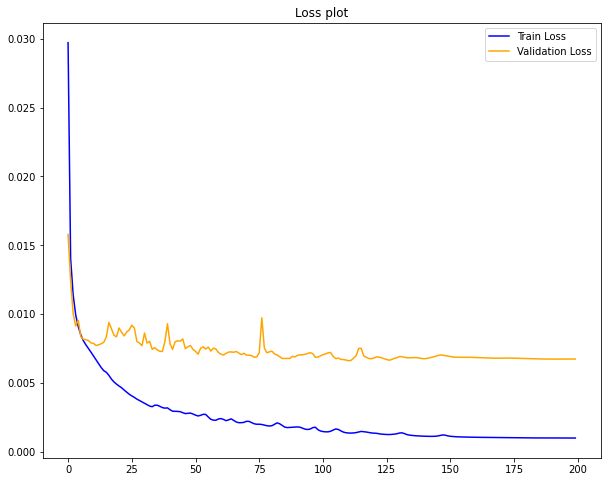

In [ ]:
fig = plt.figure(figsize=(10, 8))

fig.add_subplot(1, 1, 1)
plt.plot(train_losses, color = 'blue', label = 'Train Loss')
plt.plot(eval_losses, color = 'orange', label = 'Validation Loss')
plt.title('Loss plot')
plt.legend(loc ='upper right')

plt.show()

## Evaluation

1. Sample 36 random samples from testset (your own dataset class)
2. Give each of the 36 samples to your trained model and get the outputs
3. Visualize `input` (black-and-white image), `output` (output of the model with the given black-and-white input image) and `ground truth` (the actual RGB image)



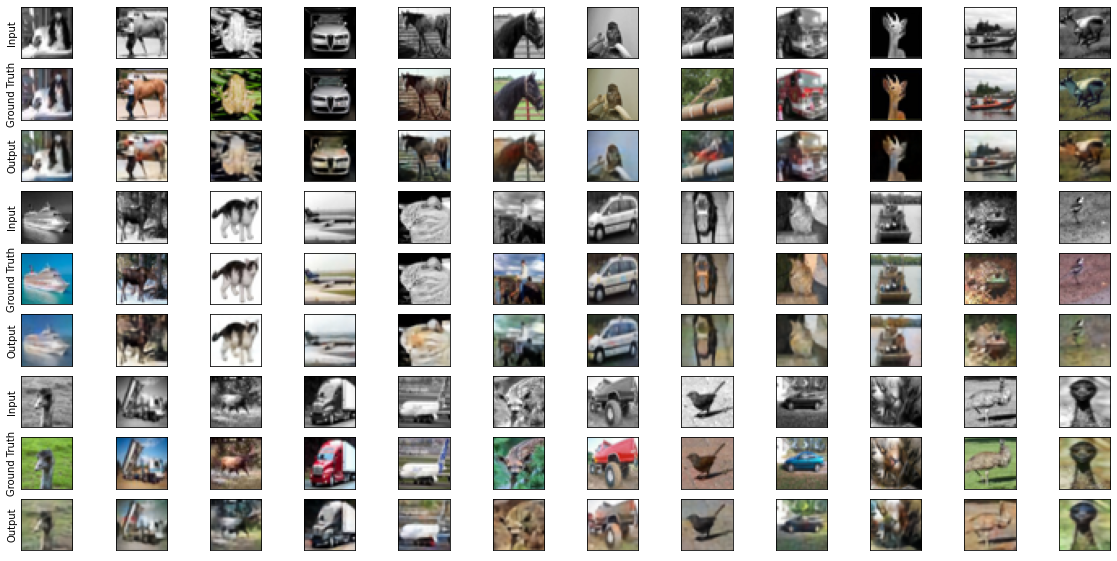

In [ ]:
indexes = torch.randperm(len(dataset.rgb_test_set))[:36]

fig = plt.figure(figsize = (20, 10))

for i in range(12):
  rgb = dataset.rgb_test_set[indexes[i]]
  gray = dataset.gray_test_set[indexes[i]]

  fig.add_subplot(9, 12, i + 1)
  gray1 = gray[-1, :, :]
  plt.imshow(gray1.numpy(), cmap = plt.get_cmap('gray'))
  plt.xticks([])
  plt.yticks([])
  plt.grid(True)
  if i == 0:
    plt.ylabel('Input')

  fig.add_subplot(9, 12, i + 13)
  plt.imshow(rgb.permute(1, 2, 0).numpy())
  plt.xticks([])
  plt.yticks([])
  plt.grid(True)
  if i == 0:
    plt.ylabel('Ground Truth')

  x = gray.unsqueeze(0)
  x = x.to(device)
  y = net(x)

  y = y.to('cpu')
  y = y.detach()

  fig.add_subplot(9, 12, i + 25)
  plt.imshow(y[0].permute(1, 2, 0).numpy())
  plt.xticks([])
  plt.yticks([])
  plt.grid(True)
  if i == 0:
    plt.ylabel('Output')

for i in range(12):
  rgb = dataset.rgb_test_set[indexes[i + 12]]
  gray = dataset.gray_test_set[indexes[i + 12]]

  fig.add_subplot(9, 12, i + 37)
  gray1 = gray[-1, :, :]
  plt.imshow(gray1.numpy(), cmap = plt.get_cmap('gray'))
  plt.xticks([])
  plt.yticks([])
  plt.grid(True)
  if i == 0:
    plt.ylabel('Input')

  fig.add_subplot(9, 12, i + 49)
  plt.imshow(rgb.permute(1, 2, 0).numpy())
  plt.xticks([])
  plt.yticks([])
  plt.grid(True)
  if i == 0:
    plt.ylabel('Ground Truth')

  x = gray.unsqueeze(0)
  x = x.to(device)
  y = net(x)

  y = y.to('cpu')
  y = y.detach()

  fig.add_subplot(9, 12, i + 61)
  plt.imshow(y[0].permute(1, 2, 0).numpy())
  plt.xticks([])
  plt.yticks([])
  plt.grid(True)
  if i == 0:
    plt.ylabel('Output')

for i in range(12):
  rgb = dataset.rgb_test_set[indexes[i + 24]]
  gray = dataset.gray_test_set[indexes[i + 24]]

  fig.add_subplot(9, 12, i + 73)
  gray1 = gray[-1, :, :]
  plt.imshow(gray1.numpy(), cmap = plt.get_cmap('gray'))
  plt.xticks([])
  plt.yticks([])
  plt.grid(True)
  if i == 0:
    plt.ylabel('Input')

  fig.add_subplot(9, 12, i + 85)
  plt.imshow(rgb.permute(1, 2, 0).numpy())
  plt.xticks([])
  plt.yticks([])
  plt.grid(True)
  if i == 0:
    plt.ylabel('Ground Truth')

  x = gray.unsqueeze(0)
  x = x.to(device)
  y = net(x)

  y = y.to('cpu')
  y = y.detach()

  fig.add_subplot(9, 12, i + 97)
  plt.imshow(y[0].permute(1, 2, 0).numpy())
  plt.xticks([])
  plt.yticks([])
  plt.grid(True)
  if i == 0:
    plt.ylabel('Output')
plt.show()
